# Quantitative Trading Strategies
# Simple Spread Trading

## FINM 33150 - 2024

* Baptiste PEPIN

### Import modules

In [771]:
import datetime
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import quandl
import statsmodels.api as sm

import config

%matplotlib inline

### 1. Introduction

In this homework, we will be implementing a spread trading strategy on 2 ETFs: **HYLD** (X) versus **JNK** (Y). This kind of strategy checks a running estimate of the displacement between two related instruments, and makes bets that this displacement will decline whenever it gets large. For our purpose, we will look at returns to define that displacement.

Our work with fall into 3 parts:
* Data Manipulation
* Trading Strategy Implementation & Optimization
* Analysis

We will first retrieve the data from Quandl and transform it for our purpose. We will then implement the strategy before trying to optimize some of its parameters. Finally, we will analyze the results of our strategy with different sets of parameters, against different benchmarks.

### 2. Data Manipulation

#### 2.1. Data Collection

We will start by retrieving the data from Quandl. We will use the Quandl Python package to do so. To perform this extraction, one need to get access to the NASDAQ API key and to set it in the code below.

The `fetch_quandl_table` function will download the data and save it in a local folder. If the data has already been downloaded, it will not be downloaded again. Instead, the function will return the path to the local file containing the data.

In [772]:
def grab_quandl_table(
        table_path,
        avoid_download=False,
        replace_existing=False,
        date_override=None,
        allow_old_file=False,
        **kwargs,
):
    root_data_dir = os.path.join(os.getcwd(), "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=config.QUANDL_API_KEY, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [773]:
prices = fetch_quandl_table('QUOTEMEDIA/PRICES')
prices.head()

Skipping any possible download of QUOTEMEDIA/PRICES


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,JTKWY,2022-03-11,6.1700,7.3200,5.790,6.72,9440097.0,0.0,1.0,6.1700,7.3200,5.790,6.72,9440097.0
1,JTKWY,2022-03-10,6.1600,6.1750,5.935,6.07,2261623.0,0.0,1.0,6.1600,6.1750,5.935,6.07,2261623.0
2,FG_1,2020-06-01,8.1000,8.3900,8.100,8.39,3086317.0,0.0,1.0,8.1000,8.3900,8.100,8.39,3086317.0
3,FLWS,2022-03-09,14.5700,14.9588,14.410,14.45,662492.0,0.0,1.0,14.5700,14.9588,14.410,14.45,662492.0
4,RENW_,2020-01-29,21.9768,21.9900,21.970,21.99,319.0,0.0,1.0,21.9768,21.9900,21.970,21.99,319.0


We also obtain daily Fama-French factor returns from Kenneth French's website. We will use the 3 factors model.

In [774]:
FF3 = pd.read_csv('http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_3_Factors_Daily_CSV.zip',
                  skiprows=3)

FF3['date'] = pd.to_datetime(FF3['Unnamed: 0'], format='%Y%m%d')
FF3.set_index('date', inplace=True)
FF3.drop('Unnamed: 0', axis=1, inplace=True)
FF3.head()

,Mkt-RF,SMB,HML,RF
date,,,,
1990-07-02,0.69,-0.06,-0.33,0.03
1990-07-03,0.18,0.07,-0.15,0.03
1990-07-04,0.62,-0.17,-0.17,0.03
1990-07-05,-0.74,0.29,0.14,0.03
1990-07-06,0.20,-0.17,0.02,0.03


#### 2.2. Data Extraction

Now that we have available the data for a lot of ETFs, we need to select the ones we need. The ETSs pair we are going to work with is the one labelled 0: **HYLD** (X) versus **JNK** (Y).

**HYLD** (Peritus High Yield ETF): This ETF focuses on high-yield corporate debt, commonly known as junk bonds. These are bonds issued by companies with lower credit ratings, meaning they are considered to be at a higher risk of default than more highly rated, investment-grade bonds. In exchange for this higher risk, they typically offer higher interest rates. It is actively managed, meaning that a fund manager makes decisions about which bonds to include in the portfolio, rather than passively tracking a specific index.

**JNK** (SPDR Bloomberg High Yield Bond ETF): This ETF also targets the high-yield bond market. Managed by State Street Global Advisors, **JNK** aims to track the performance of the Bloomberg Barclays High Yield Very Liquid Index. This index includes publicly issued U.S. dollar-denominated, non-investment grade, fixed-rate, taxable corporate bonds. As a passive ETF, **JNK** seeks to replicate the index's composition and performance, so its holdings are a broad representation of the junk bond market.

We will also need the data for the **SVOL** volatility ETF which is a rough proxy for the market's expected volatility and activity.

To get the data on those ETFs, we will filter the data downloaded from Quandl above. Since we are only interested in the period between 2 December 2021 and 15 November 2023, we will use a second filter to only keep those dates.

In [775]:
# Parameters

SVOL = 'SVOL'

## Pair 0
X_old = 'HYLD'
X = 'RINC'  # HYLD ticker as been replaced by RINC
Y = 'JNK'

## Dates
start_date = '2021-12-02'
end_date = '2023-11-15'

In [776]:
def get_data_from_ticker(data, code):
    return data[data['ticker'] == code]


def filter_data_on_dates(data, start_date, end_date):
    if 'date' in data.columns:
        return data[(data['date'] >= start_date) & (data['date'] <= end_date)]
    else:
        return data[(data.index >= start_date) & (data.index <= end_date)]

In [777]:
# Get the data for SVOL and filter

SVOL_data = get_data_from_ticker(prices, SVOL)
SVOL_data = filter_data_on_dates(SVOL_data, start_date, end_date)

# Get the data for X and filter

X_data = get_data_from_ticker(prices, X)
X_data = filter_data_on_dates(X_data, start_date, end_date)

# Get the data for Y and filter

Y_data = get_data_from_ticker(prices, Y)
Y_data = filter_data_on_dates(Y_data, start_date, end_date)

# Filter the data for FF3

FF3 = filter_data_on_dates(FF3, start_date, end_date)

#### 2.3. Data Cleaning

Before starting the analysis, we also need to clean the data. We will first check if there are any missing values in our dataframes, and then transform and align their dates.

As a choice, we decided to drop the missing values in our ETFs.

In [778]:
def clean_data_if_missing_values(data):
    if data.isnull().values.any():
        print('There are missing values in the data')
        data.dropna(inplace=True)
        print('Missing values have been removed')
    else:
        print('There are no missing values in the data')

In [779]:
clean_data_if_missing_values(SVOL_data)

clean_data_if_missing_values(X_data)

clean_data_if_missing_values(Y_data)

There are no missing values in the data
There are no missing values in the data
There are no missing values in the data


In [780]:
def clean_data_FF3(data):
    # Missing data are indicated by -99.99.
    # We will replace them by NaN and then remove them.
    data.replace(-99.99, np.nan, inplace=True)
    clean_data_if_missing_values(data)

In [781]:
clean_data_FF3(FF3)

There are no missing values in the data


We will now convert the dates to datetime objects and set them as the index of the dataframes so that we can easily manipulate them.

In [782]:
def date_to_datetime(data):
    if 'date' in data.columns:
        data.loc[:, 'date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data.set_index('date', inplace=True)
        data.sort_index(inplace=True)
    else:
        data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
        data.sort_index(inplace=True)

In [783]:
date_to_datetime(SVOL_data)

date_to_datetime(X_data)

date_to_datetime(Y_data)

date_to_datetime(FF3)

Now we will check if the dataframes have the same dates. Otherwise, we will remove the dates that are not in all of them, to have the same time series and to be able to compare them. To do so, we first try to find the one with the least dates and then align the other dataframes on its dates.

In [784]:
print(f'The SVOL dataframe has {SVOL_data.shape[0]} dates')
print(f'The X dataframe has {X_data.shape[0]} dates')
print(f'The Y dataframe has {Y_data.shape[0]} dates')
print(f'The FF3 dataframe has {FF3.shape[0]} dates')

The SVOL dataframe has 492 dates
The X dataframe has 492 dates
The Y dataframe has 492 dates
The FF3 dataframe has 510 dates


So here we will try to align all the dataframes on the dates of the X dataframe for example.

In [785]:
def drop_index_difference(data1, data2):
    data1.drop(data1.index.difference(data2.index), inplace=True)
    data2.drop(data2.index.difference(data1.index), inplace=True)

In [786]:
drop_index_difference(X_data, SVOL_data)

drop_index_difference(X_data, Y_data)

drop_index_difference(X_data, FF3)

Finally, we can check that the dataframes all have the same dates.

In [787]:
(X_data.index == SVOL_data.index).all() and (SVOL_data.index == Y_data.index).all() and (
        Y_data.index == FF3.index).all()

True

#### 2.4. Data Visualization

Before going further into our work, let's visualize the data we have but our two high-yield bond ETFs.

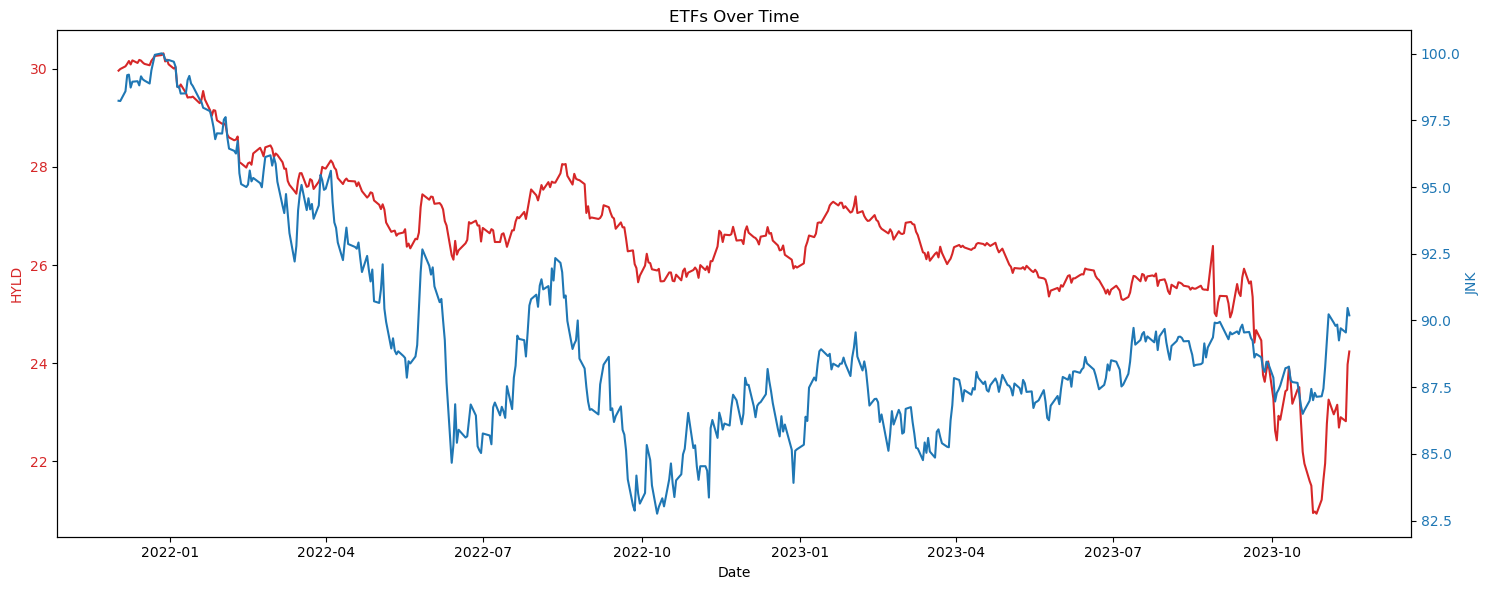

In [788]:
plt.figure(figsize=(15, 6))

ax1 = plt.subplot(111)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel(f'{X_old}', color=color)
ax1.plot(X_data.index, X_data['adj_close'], label=X, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel(f'{Y}', color=color)
ax2.plot(Y_data.index, Y_data['adj_close'], label=Y, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('ETFs Over Time')
plt.tight_layout()
plt.show()

We can see that the 2 ETFs have a similar behavior over time. It looks like they are quite strongly correlated. Nevertheless, they do diverge from time to time, which means that their spread is widening, this could therefore represent a trading opportunity for us considering the fact that those two ETFs are similar in their nature (high-yield bond ETFs).

In [789]:
print(
    f'The correlation between {X_old} ({X}) and {Y} is {X_data["adj_close"].corr(Y_data["adj_close"]):.2%} between {start_date} and {end_date}.')

The correlation between HYLD (RINC) and JNK is 67.49% between 2021-12-02 and 2023-11-15.


### 3. Trading Strategy Implementation & Optimization

We will now be coding a spread-reversion trading strategy, along with a stop-loss mechanism. As we observed before, we expect the spread between the 2 ETFs to revert to its mean when it is too large. We will therefore be opening a position when the spread gets larger before closing it when it gets smaller.

In [790]:
data = pd.DataFrame({
    'X_price': X_data['adj_close'],
    'Y_price': Y_data['adj_close']
})

#### 3.1. Preliminary Work

First, we will compute a new variable that we will build as a running trailing 15-day median of the daily dollar volume for our 2 ETFs. This will be useful to determine which ETF is the less liquid and to size our positions.

In [791]:
def compute_daily_dollar_volume(data):
    return data['adj_close'] * data['adj_volume']


def compute_running_median(data, window=15):
    return data.rolling(window).median()


def compute_N_t(data1, data2, window=15):
    daily_dollar_volume1 = compute_daily_dollar_volume(data1)
    daily_dollar_volume2 = compute_daily_dollar_volume(data2)

    running_median1 = compute_running_median(daily_dollar_volume1, window)
    running_median2 = compute_running_median(daily_dollar_volume2, window)

    if running_median1.min() > running_median2.max():
        return running_median2
    elif running_median2.min() > running_median1.max():
        return running_median1
    else:
        print(
            'The running medians of the 2 ETFs are overlapping. We cannot determine which one is the less liquid with this basic method.')
        print('We will use the one with the smallest median.')
        return running_median1 if running_median1.min() < running_median2.min() else running_median2

In [792]:
N_t = compute_N_t(X_data, Y_data).shift()

#### 3.2. Parameters definition and visualization

Now, let's define the parameters of our strategy. Those values are chosen arbitrarily and will be optimized later on.

In [793]:
start_trading_date = '2022-01-01'
end_trading_date = '2023-11-15'  # Close all existing positions on this date

# Parameters
M = 10  # Number of days for M-day return
g = 0.020  # Threshold for entering a position
j = 0.005  # Threshold for exiting a position - must be lower than g
s = 0.05  # Stop loss parameter
K = 2 * N_t.loc[start_trading_date:end_trading_date].max()  # Capital

trading_cost = True  # Whether to include trading cost

if trading_cost:
    zeta = 0.00001  # Trading cost parameter
else:
    zeta = 0

In order to better visualize those parameters and understand what they mean, we will plot the spread over time, along with the thresholds for entering and exiting a position, and the stop loss.

On the top part of the graph, we can see that we are entering a position when the spread is above the green line and exiting it when it is below the red line. We also have a stop loss mechanism that will close our position if the spread goes above the blue line. The same logic applies on the bottom part of the graph.

In [794]:
def plot_spread_over_time(M, g, j, s, data, open_position_date=None, close_position_date=None):
    # Compute M-day returns for X and Y
    X_return = data['X_price'].pct_change(periods=M)
    Y_return = data['Y_price'].pct_change(periods=M)

    plt.figure(figsize=(15, 6))

    plt.plot(X_return.index, X_return - Y_return, label='Spread')

    plt.axhline(y=j, color='r', linestyle='-', label='Exit Position')
    plt.axhline(y=-j, color='r', linestyle='-')
    plt.axhline(y=g, color='g', linestyle='-', label='Enter Position')
    plt.axhline(y=-g, color='g', linestyle='-')
    if s != 0:
        plt.axhline(y=s, color='b', linestyle='--', label='Stop Loss')
    plt.axhline(y=-s, color='b', linestyle='--')

    plt.axhspan(j, g, alpha=0.5, color='grey')
    plt.axhspan(-j, -g, alpha=0.5, color='grey')

    if open_position_date is not None and close_position_date is not None:
        open_position = X_return.loc[open_position_date] - Y_return.loc[open_position_date]
        close_position = X_return.loc[close_position_date] - Y_return.loc[close_position_date]

        plt.scatter(open_position_date, open_position, color='g', marker='^', s=50, label='Open Position')
        plt.scatter(close_position_date, close_position, color='r', marker='v', s=50, label='Close Position')

    plt.tight_layout()
    plt.title('Spread M-day returns over time')
    plt.xlabel('Date')
    plt.ylabel('Spread Value')

    plt.legend()

    plt.tight_layout()
    plt.show()

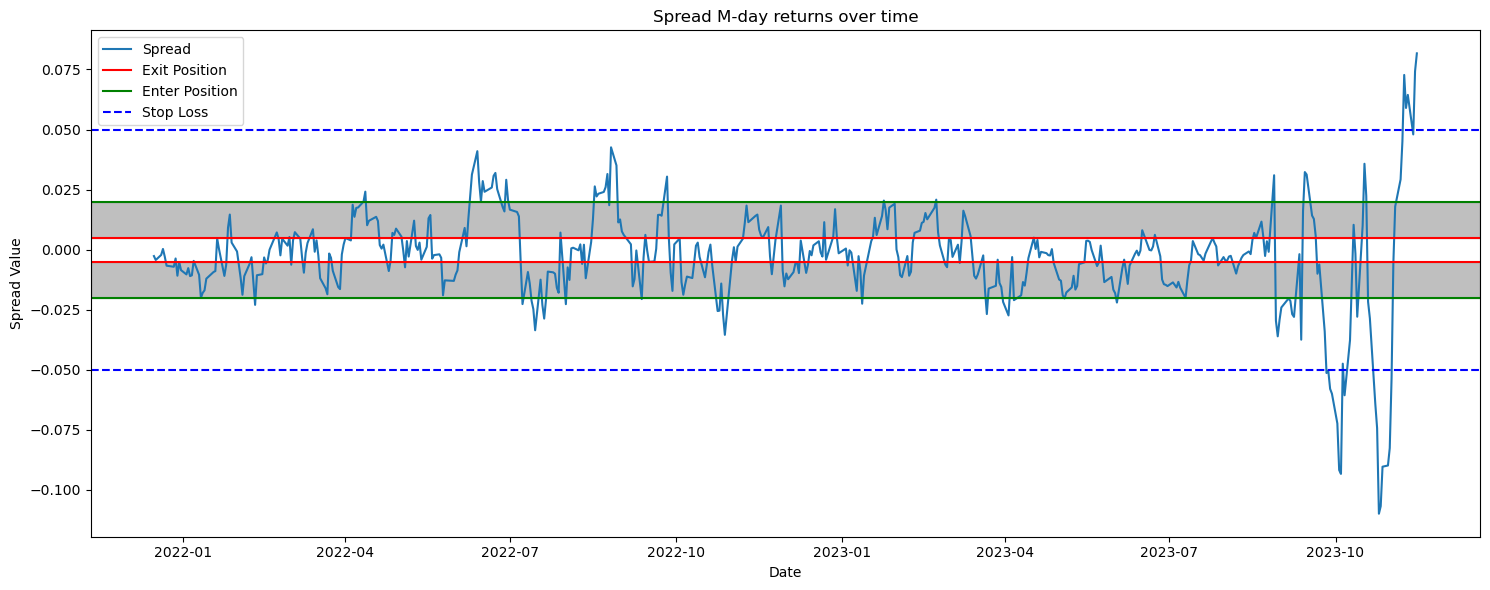

In [795]:
plot_spread_over_time(M, g, j, s, data)

Let's just precise that the stop loss represented on the graph is not exactly the one we will use in our strategy. Indeed, we will use the gross trading cash of our position to calculate the stop loss. This is because we want to take a decision on when to close a position based on the PnL of that same position, in regard to the gross trading cash of the position. This is a more realistic approach than taking a fixed threshold on the spread value.

#### 3.3. Trading Logic

We will now implement the trading logic using the parameters defined earlier. To do so, we will define different functions that will be called in the main function `trading_logic`.

The functions that we will define just after will modify an object that we call `position`. This object will be a dictionary that will contain the following information:
* `entry_date`: The date at which the position was opened
* `entry_value`: The value of the position at the entry date
* `current_value`: The current value of the position
* `X_short`: Whether we are shorting X or not
* `X_shares`: The number of shares of X we are holding
* `Y_shares`: The number of shares of Y we are holding
* `gross_trading_cash`: The gross trading cash of the position
* `position_pnl`: The PnL of the position

A first function `open_position` will be used to open a position. It will take as arguments the date, the current prices of the 2 ETFs, the size of the trade, whether we are shorting X or not, the current cumulative PnL, the trading cost parameter and the position we are closing (if any). It will return the new position and the updated cumulative PnL. If we are closing a position, we will use the `closed_position` argument to pass the position we are closing to the function in order to keep track of the PnL of this position.

As a choice when opening a position while closing another one on the same day, we will keep the gross trading cash of the position we are opening to save in our data. Nevertheless, trading costs for closing and opening a position will be calculated using the gross trading cash of the position we are closing and opening respectively.

This last comment introduces our second function `close_position` which will be used to close a position. It will take as arguments the date, the current prices of the 2 ETFs, the position we are closing, the current cumulative PnL and the trading cost parameter. It will return the new position and the updated cumulative PnL.

Finally, we will define a third function `update_position` which will work similarly to the two previous ones but will be used to update a position and the cumulative PnL.

In [796]:
def open_position(date, current_price_X, current_price_Y, trade_size, X_short, cumulative_pnl, zeta,
                  closed_position=None):
    X_share_size = np.round(trade_size / current_price_X)
    Y_share_size = np.round(trade_size / current_price_Y)

    if closed_position:
        position_pnl = closed_position['position_pnl']
        position_daily_pnl = closed_position['position_daily_pnl']
    else:
        position_pnl = 0
        position_daily_pnl = 0

    if X_short:
        entry_value = -X_share_size * current_price_X + Y_share_size * current_price_Y
        X_shares, Y_shares = -X_share_size, Y_share_size
    else:
        entry_value = X_share_size * current_price_X - Y_share_size * current_price_Y
        X_shares, Y_shares = X_share_size, -Y_share_size

    gross_trading_cash = abs(X_share_size) * current_price_X + abs(Y_share_size) * current_price_Y

    position = {
        'entry_date': date,
        'entry_value': entry_value,
        'current_value': entry_value,
        'X_short': X_short,
        'X_shares': X_shares,
        'Y_shares': Y_shares,
        'gross_trading_cash': gross_trading_cash,
        'position_pnl': position_pnl,
        'position_daily_pnl': position_daily_pnl
    }

    entry_cost = zeta * gross_trading_cash

    cumulative_pnl -= entry_cost

    return position, cumulative_pnl

In [797]:
def close_position(date, position, cumulative_pnl, zeta):
    position = {
        'entry_date': date,
        'entry_value': 0,
        'current_value': 0,
        'X_short': None,
        'X_shares': 0,
        'Y_shares': 0,
        'gross_trading_cash': position['gross_trading_cash'],
        'position_pnl': position['position_pnl'],
        'position_daily_pnl': position['position_daily_pnl']
    }

    exit_cost = zeta * position['gross_trading_cash']

    cumulative_pnl -= exit_cost

    return position, cumulative_pnl

In [798]:
def update_position(current_price_X, current_price_Y, position, cumulative_pnl):
    last_value = position['current_value']

    position['current_value'] = position['X_shares'] * current_price_X + position['Y_shares'] * current_price_Y

    position['gross_trading_cash'] = abs(position['X_shares']) * current_price_X + abs(
        position['Y_shares']) * current_price_Y

    position['position_pnl'] = position['current_value'] - position['entry_value']

    position['position_daily_pnl'] = position['current_value'] - last_value

    cumulative_pnl += position['current_value'] - last_value

    return position, cumulative_pnl

The next Python function, `trading_logic`, is designed to implement a trading strategy over a specified date range using provided market data. It begins by preparing the data and establishing trading parameters. The data is copied to preserve the original dataset, and the capital (K) is determined based on the maximum value of a specified series (N_t) over the trading period. Additionally, the function calculates the returns of the two ETFs, X and Y, over a period of M days, which are central to the trading decisions.

The core of the function is a loop that iterates over each trading day within the specified period. On each day, it evaluates whether to open, close, or maintain positions based on the calculated returns and predefined thresholds (g for entry, j for exit, and s for stop-loss). The logic includes conditions for entering a position when the absolute difference in asset returns (z) exceeds the entry threshold (g), and for exiting when z falls below the exit threshold (j) or a stop-loss condition is met. The stop-loss mechanism is designed to limit losses, triggering a position closure if the loss exceeds a certain proportion of the gross trading cash. Additionally, after a stop-loss event, no new positions are opened until the start of the next month, as indicated by a reset flag.

The function meticulously records the trading activity and position details for each day, including the cumulative profit and loss (PnL), positions in each asset, and cash involved in trades. This daily record is compiled into a comprehensive trading dataframe, which provides a detailed view of the strategy's performance over time. Finally, the function ensures all positions are closed by the end date, updating the last day's record to reflect this. The returned dataframe is a thorough log of the trading strategy, detailing every action taken and its impact on the overall PnL, essential for analyzing the strategy's effectiveness.

To note, we are computing different PnLs in our strategy. The first one is the cumulative realized PnL which is the cumulative sum of all the PnLs of the positions we have opened, it also includes the trading costs for opening and closing positions. The second one is the position cumulative PnL of the position we are currently holding. This means it is equal to 0 on the day we open a position and is equal to the total PnL of the position we are closing on the day we close it (on that line, the quantity of shares of X and Y are equal to 0 because we closed the position). The third one is the daily PnL of the position which is the PnL of the position we are currently holding since the last day.

In [799]:
def trading_logic(M, g, j, s, zeta, start_trading_date, end_trading_date, datas, N_t):
    data = datas.copy()
    K = 2 * N_t.loc[start_trading_date:end_trading_date].max()
    dollars_size_positions = (N_t / 100).loc[start_trading_date:end_trading_date]

    data['X_return'] = data['X_price'].pct_change(periods=M)
    data['Y_return'] = data['Y_price'].pct_change(periods=M)

    positions = []
    trading_record = []
    cumulative_pnl = 0
    number_of_trades = 0

    stop_loss_need_reset = False
    no_trading_dates = []  # Dates where we don't trade because of our stop loss
    gross_traded_cash_entry = 0

    for i in data.loc[start_trading_date:end_trading_date].index:
        current_price_X = data.loc[i, 'X_price']
        current_price_Y = data.loc[i, 'Y_price']

        daily_record = {'date': i, 'cumulative_pnl': cumulative_pnl, 'position_pnl': 0, 'position_daily_pnl': 0,
                        'X_shares': 0, 'Y_shares': 0, 'gross_trading_cash': 0, 'num_trade': number_of_trades,
                        'X_price': current_price_X, 'Y_price': current_price_Y, 'stop_loss_threshold': 0}

        # Calculate the size of the difference z
        z = data.loc[i, 'X_return'] - data.loc[i, 'Y_return']

        # Update or close positions if we reach the stop loss
        if positions:
            position, cumulative_pnl = update_position(current_price_X, current_price_Y, positions.pop(),
                                                       cumulative_pnl)
            positions.append(position)

            # Check stop loss
            if position['position_pnl'] < - s * gross_traded_cash_entry:
                closed_position, cumulative_pnl = close_position(i, positions.pop(), cumulative_pnl, zeta)
                no_trading_dates.append(i)
                stop_loss_need_reset = True

        if not stop_loss_need_reset:
            # Entry logic
            if not positions and abs(z) > g:
                position, cumulative_pnl = open_position(i, current_price_X, current_price_Y,
                                                         dollars_size_positions.loc[i],
                                                         data.loc[i, 'X_return'] > data.loc[i, 'Y_return'],
                                                         cumulative_pnl, zeta)
                positions.append(position)
                number_of_trades += 1
                gross_traded_cash_entry = data.loc[position['entry_date'], 'X_price'] * abs(position['X_shares']) + \
                                          data.loc[position['entry_date'], 'Y_price'] * abs(position['Y_shares'])

            elif positions and abs(z) > g and (
                    positions[-1]['X_short'] != (data.loc[i, 'X_return'] > data.loc[i, 'Y_return'])):
                closed_position, cumulative_pnl = close_position(i, positions.pop(), cumulative_pnl, zeta)

                position, cumulative_pnl = open_position(i, current_price_X, current_price_Y,
                                                         dollars_size_positions.loc[i],
                                                         data.loc[i, 'X_return'] > data.loc[i, 'Y_return'],
                                                         cumulative_pnl, zeta, closed_position=closed_position)
                positions.append(position)
                number_of_trades += 1

            elif positions and z < j and positions[-1]['X_short']:
                closed_position, cumulative_pnl = close_position(i, positions.pop(), cumulative_pnl, zeta)
            elif positions and z > -j and not positions[-1]['X_short']:
                closed_position, cumulative_pnl = close_position(i, positions.pop(), cumulative_pnl, zeta)

        else:
            # After the end of current month, reset stop loss
            if i.month != (i + datetime.timedelta(days=1)).month:
                stop_loss_need_reset = False

        # Update daily record with position details
        if positions:
            position = positions[-1]
            daily_record['cumulative_pnl'] = cumulative_pnl
            daily_record['X_shares'] = position['X_shares']
            daily_record['Y_shares'] = position['Y_shares']
            daily_record['gross_trading_cash'] = position['gross_trading_cash']
            daily_record['position_pnl'] = position['position_pnl']
            daily_record['position_daily_pnl'] = position['position_daily_pnl']
            daily_record['num_trade'] = number_of_trades
            daily_record['stop_loss_threshold'] = - s * gross_traded_cash_entry
        else:
            daily_record['cumulative_pnl'] = cumulative_pnl
            daily_record['X_shares'] = 0
            daily_record['Y_shares'] = 0
            try:
                daily_record['gross_trading_cash'] = closed_position['gross_trading_cash']
                daily_record['position_pnl'] = closed_position['position_pnl']
                daily_record['position_daily_pnl'] = closed_position['position_daily_pnl']
                closed_position = None
                daily_record['stop_loss_threshold'] = - s * gross_traded_cash_entry
            except:
                daily_record['gross_trading_cash'] = 0
                daily_record['position_pnl'] = 0
                daily_record['position_daily_pnl'] = 0

        trading_record.append(daily_record)

    # Ensure all positions are closed on the end_trading_date
    if positions:
        closed_position, cumulative_pnl = close_position(end_trading_date, positions.pop(), cumulative_pnl, zeta)

    # Update the final day's record
    trading_record[-1]['cumulative_pnl'] = cumulative_pnl
    trading_record[-1]['X_shares'] = 0
    trading_record[-1]['Y_shares'] = 0
    try:
        trading_record[-1]['gross_trading_cash'] = closed_position['gross_trading_cash']
        trading_record[-1]['position_pnl'] = closed_position['position_pnl']
        trading_record[-1]['position_daily_pnl'] = closed_position['position_daily_pnl']
        trading_record[-1]['stop_loss_threshold'] = - s * gross_traded_cash_entry
    except:
        trading_record[-1]['gross_trading_cash'] = 0
        trading_record[-1]['position_pnl'] = 0
        trading_record[-1]['position_daily_pnl'] = 0

    trading_df = pd.DataFrame(trading_record)

    trading_df.rename(columns={'date': 'Date', 'X_shares': f'Shares of {X_old} (X)', 'Y_shares': f'Shares of {Y} (Y)',
                               'gross_trading_cash': 'Gross Trading Cash', 'position_pnl': 'Position Cumulative PnL',
                               'position_daily_pnl': 'Position Daily PnL', 'cumulative_pnl': 'Cumulative Realized PnL',
                               'X_price': f'Price of {X_old} (X)', 'Y_price': f'Price of {Y} (Y)',
                               'num_trade': 'Number of Trades', 'stop_loss_threshold': 'Stop Loss Threshold'},
                      inplace=True)
    trading_df.set_index('Date', inplace=True)

    return trading_df, K, no_trading_dates

Now let's run our strategy on the initial parameters defined earlier and see what we get. The `trading_logic` function will return a dataframe that contains all the information we need to analyze our strategy, along with the capital associated to it and the potential dates where we don't trade because of our stop loss.

In [800]:
trading_df, K, no_trading_dates = trading_logic(M, g, j, s, zeta, start_trading_date,
                                                end_trading_date, data, N_t)
trading_df.tail()

,Cumulative Realized PnL,Position Cumulative PnL,Position Daily PnL,Shares of HYLD (X),Shares of JNK (Y),Gross Trading Cash,Number of Trades,Price of HYLD (X),Price of JNK (Y),Stop Loss Threshold
Date,,,,,,,,,,
2023-11-09,576.929688,8.773754,26.607523,-84.0,21.0,3780.275128,28,22.6899,89.253501,-190.843909
2023-11-10,568.784226,0.628293,-8.145461,-84.0,21.0,3807.527267,28,22.9006,89.708422,-190.843909
2023-11-13,572.265326,4.109393,3.481100,-84.0,21.0,3797.400367,28,22.8196,89.550189,-190.843909
2023-11-14,494.400085,-73.755848,-77.865241,-84.0,21.0,3913.894326,28,23.9765,90.469920,-190.843909
2023-11-15,466.411707,-101.704924,-27.949076,0.0,0.0,3930.213250,28,24.2400,90.193012,-190.843909


In [801]:
def print_performance_metrics(trading_df, K):
    print(
        f'The final cumulative realized PnL of our strategy is ${trading_df.iloc[-1]["Cumulative Realized PnL"]:.2f}.')
    print(f'The return on capital is {trading_df.iloc[-1]["Cumulative Realized PnL"] / K:.4%}.')


print_performance_metrics(trading_df, K)

The final cumulative realized PnL of our strategy is $466.41.
The return on capital is 0.0275%.


First thing we can notice here is that we placed 28 trades over the period of study (about 2 years) and our strategy is profitable with a cumulative realized PnL of \$466 (trading costs included). The stop loss mechanism in this scenario is not triggered (`no_trading_dates` is empty).

We can also see that we are holding a position until the last day of our study. We said earlier that we would close all our positions on the end date, so this last position is closed, impacting our cumulative realized PnL with a loss.

We can visualize the evolution of our cumulative realized PnL over time and the different open and close positions dates, before trying to optimize our strategy and looking at some performance metrics other than the PnL and return on capital.

In [802]:
def get_open_close_positions_dates(trading_df):
    open_positions_dates = \
        trading_df[trading_df['Shares of HYLD (X)'] != 0].reset_index().groupby('Number of Trades').first()['Date']
    close_positions_dates = trading_df.shift()[trading_df.shift()['Shares of HYLD (X)'] != 0].reset_index().groupby(
        ['Number of Trades']).last()['Date']

    return open_positions_dates, close_positions_dates

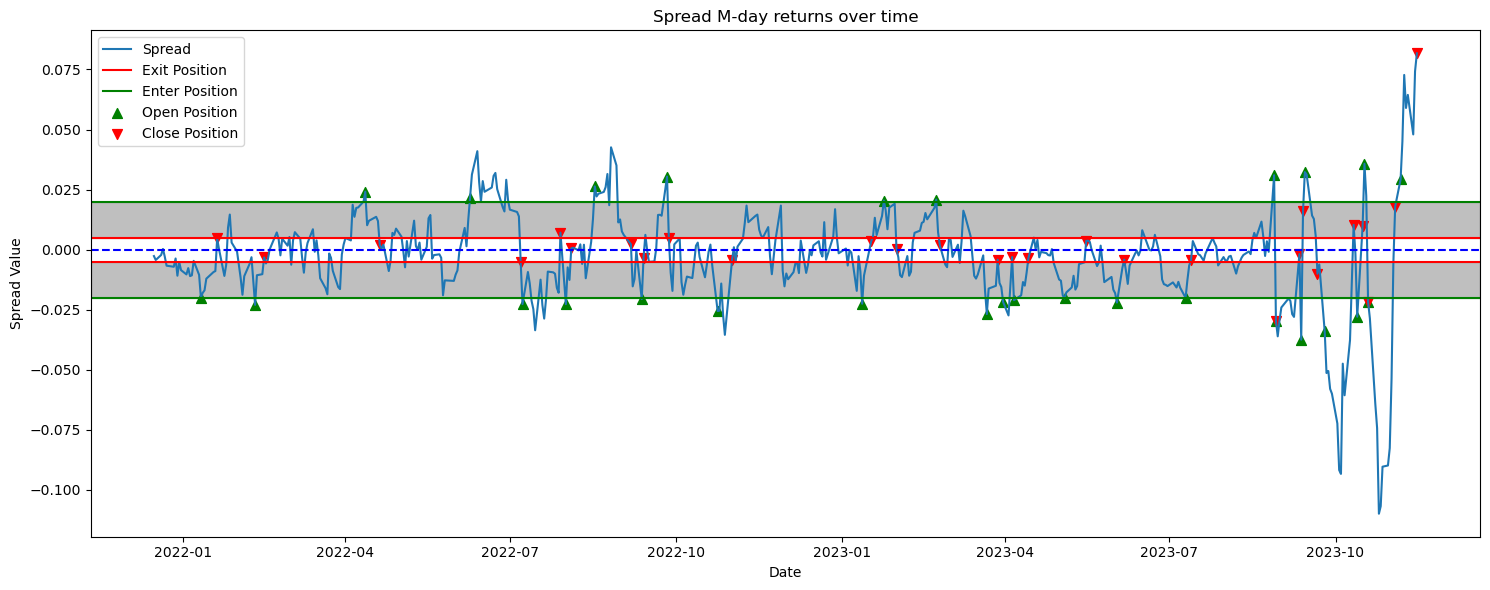

In [803]:
open_positions_dates, close_positions_dates = get_open_close_positions_dates(trading_df)

plot_spread_over_time(M, g, j, 0, data, open_positions_dates, close_positions_dates)

This graph shows on the spread, the dates when we decided to open and close a position. We can see that we are opening a position when the spread is above the green line and closing it when it crosses the closest red line. The stop loss is not represented here because we didn't reach it in this scenario and because in our trading logic, it depends on the gross trading cash of the position we are opening and closing, which is not represented on this graph.

In [804]:
def plot_pnl_over_time(trading_df, no_trading_dates):
    plt.figure(figsize=(15, 6))

    plt.plot(trading_df.index, trading_df['Cumulative Realized PnL'], label='Cumulative Realized PnL')
    plt.plot(trading_df.index, trading_df['Position Cumulative PnL'], label='Position Cumulative PnL')

    plt.plot(trading_df.index, trading_df['Stop Loss Threshold'], label='Stop Loss')

    for date in no_trading_dates:
        plt.axvspan(date, date + pd.offsets.MonthEnd(), alpha=0.5, color='grey')

    plt.axhline(y=0, color='k', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('PnL')

    plt.legend()
    plt.tight_layout()
    plt.show()

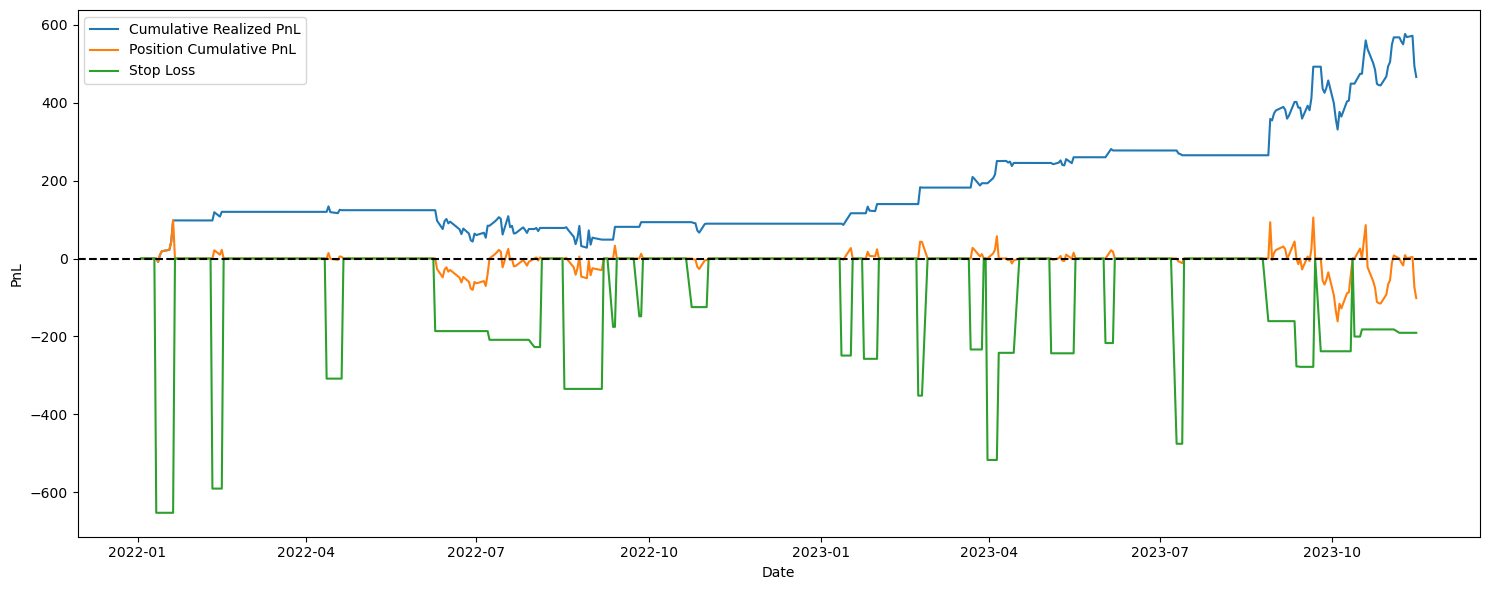

In [805]:
plot_pnl_over_time(trading_df, no_trading_dates)

On the graph above, we represented the cumulative realized PnL of our strategy along with the cumulative PnL of the position we are holding on each date. We can see that the cumulative realized PnL is always above the cumulative PnL of the position (which resets to zero when we close a position), this makes sense because of the way we are closing our positions with the exit threshold j. The green line represents our stop-loss threshold. We can see that it is never reached in this scenario, because the position cumulative PnL never crosses the green line.

#### 3.2. Strategy Optimization

We will, now that we better understand how our strategy works, try to optimize it. To do so, we will use two different methods to find the best parameters. Our objective function will be the cumulative realized PnL of our strategy, even if it is not the only metric we should look at to evaluate our strategy. This choice allows us to have a simple objective function to optimize and therefore be able to work with linear optimization methods.

Before going through the optimization process, we will first try to understand which parameters should be working well based on our data. If we first compute the spread for different values of M, we observe that for small values of M, the spread gets a little less volatile, but it gets more mean-reverting toward 0 as reported in the dataframe below with the distance between the mean and 0 getting bigger as M gets larger and the volatility getting bigger too. Therefore, we should find some low values of M in our optimization, allowing for more trade opportunities and a better mean-reversion strategy. Looking now at the thresholds, it seems logic to have something symmetric around 0. The smaller they get, the easiest it will be for us to trade because the more frequent it will be for the spread to cross those thresholds. Moreover, to get an idea of the threshold values we could take, we can have a look at some quantiles. If we balance the small thresholds with a strong mean-reversion spread, we can expect to have profits. Finally, the stop loss parameter should be small enough to limit our losses but not too small to be triggered too often. We will see later that we will find a value of 0.01 for this parameter which is 5 times smaller than the one we initially chose.

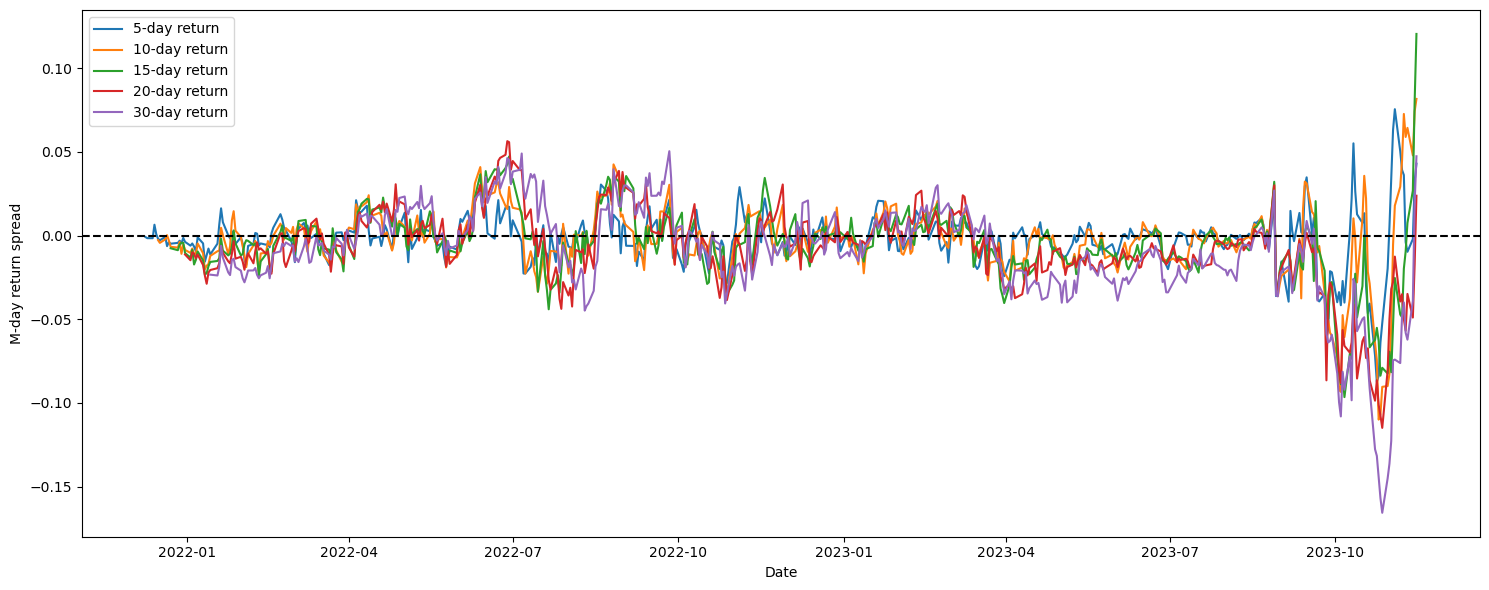

,Mean,Volatility,95% quantile,75% quantile,50% quantile,25% quantile,5% quantile
5-day return spread,-0.001561,0.015738,0.020842,0.005214,-0.001363,-0.006727,-0.023738
10-day return spread,-0.003283,0.020895,0.026020,0.005336,-0.002696,-0.011410,-0.029275
15-day return spread,-0.005644,0.021780,0.027440,0.004546,-0.004655,-0.014266,-0.044322
20-day return spread,-0.007753,0.023291,0.026120,0.004372,-0.006832,-0.017120,-0.049329
30-day return spread,-0.010290,0.029897,0.030739,0.007188,-0.007767,-0.022249,-0.061993


In [806]:
plt.figure(figsize=(15, 6))

data_spread = data.copy()

for M in [5, 10, 15, 20, 30, ]:
    data_spread[f'{M}-day return spread'] = data_spread['X_price'].pct_change(periods=M) - data_spread[
        'Y_price'].pct_change(periods=M)

    plt.plot(data_spread.index, data_spread[f'{M}-day return spread'], label=f'{M}-day return')

plt.axhline(y=0, color='k', linestyle='--')

plt.xlabel('Date')
plt.ylabel('M-day return spread')

plt.legend()
plt.tight_layout()
plt.show()

data_spread_df = data_spread.mean().to_frame('Mean')[2:]
data_spread_df['Volatility'] = data_spread.std()[2:]
data_spread_df['95% quantile'] = data_spread.quantile(0.95)[2:]
data_spread_df['75% quantile'] = data_spread.quantile(0.75)[2:]
data_spread_df['50% quantile'] = data_spread.quantile(0.50)[2:]
data_spread_df['25% quantile'] = data_spread.quantile(0.25)[2:]
data_spread_df['5% quantile'] = data_spread.quantile(0.05)[2:]

data_spread_df

##### 3.2.1. Grid Search

For this first methods, we will use a simple grid search method to find the best parameters. The values that the parameters can take are being defined manually for the grid search to explore. We will then iterate over all the possible combinations of parameters and keep the ones that maximize the cumulative realized PnL.

In [807]:
def grid_search(M, g, j, s, zeta, start_trading_date, end_trading_date, datas, N_t):
    trading_df, _, _ = trading_logic(M, g, j, s, zeta, start_trading_date, end_trading_date, datas, N_t)
    return trading_df.iloc[-1]['Cumulative Realized PnL']

In [808]:
M_grid = [5, 10, 15, 20, 25, 30, 35, 40]  # Number of days for M-day return
g_grid = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]  # Threshold for entering a position
j_grid = [0.005, 0.01, 0.015, 0.02, 0.025]  # Threshold for exiting a position - must be lower than g
s_grid = [0.01, 0.02, 0.03, 0.04, 0.05]  # Stop loss parameter
zeta_grid = [0.00001, 0]  # Trading cost parameter

In [809]:
best_cumulative_pnl = 0
best_parameters = None

for [M, g, j, s, zeta] in itertools.product(M_grid, g_grid, j_grid, s_grid, zeta_grid):
    if j >= g:
        continue
    cumulative_pnl = grid_search(M, g, j, s, zeta, start_trading_date, end_trading_date, data, N_t)
    if cumulative_pnl > best_cumulative_pnl:
        best_cumulative_pnl = cumulative_pnl
        best_parameters = (M, g, j, s, zeta)
        print(f'New best parameters: M={M}, g={g}, j={j}, s={s}, zeta={zeta}')
        print(f'New best cumulative PnL: ${best_cumulative_pnl:.2f}')

New best parameters: M=5, g=0.01, j=0.005, s=0.01, zeta=1e-05
New best cumulative PnL: $895.59
New best parameters: M=5, g=0.01, j=0.005, s=0.01, zeta=0
New best cumulative PnL: $902.01


It seems that 5 days return is a very good parameter for our case which makes sense because as we have seen above, it allows for a more mean-reverting spread. Combined with low thresholds, this allows us to trade more often and to make small profits. The stop loss parameter is also very small, which is a good thing because we want to limit our losses as much as possible.

Let's use one of the best parameters we found and see what does the strategy look like. For our study, we will go with the first result in order to include trading costs.

In [810]:
start_trading_date = '2022-01-01'
end_trading_date = '2023-11-15'

# Parameters
M_grid_search = 5  # Number of days for M-day return
g_grid_search = 0.01  # Threshold for entering a position
j_grid_search = 0.005  # Threshold for exiting a position - must be lower than g
s_grid_search = 0.01  # Stop loss parameter

trading_cost = True  # Whether to include trading cost

if trading_cost:
    zeta = 0.00001  # Trading cost parameter
else:
    zeta = 0

,Cumulative Realized PnL,Position Cumulative PnL,Position Daily PnL,Shares of HYLD (X),Shares of JNK (Y),Gross Trading Cash,Number of Trades,Price of HYLD (X),Price of JNK (Y),Stop Loss Threshold
Date,,,,,,,,,,
2023-11-09,895.58706,0.0,0.0,0.0,0.0,0.0,54,22.6899,89.253501,0.0
2023-11-10,895.58706,0.0,0.0,0.0,0.0,0.0,54,22.9006,89.708422,0.0
2023-11-13,895.58706,0.0,0.0,0.0,0.0,0.0,54,22.8196,89.550189,0.0
2023-11-14,895.58706,0.0,0.0,0.0,0.0,0.0,54,23.9765,90.469920,0.0
2023-11-15,895.58706,0.0,0.0,0.0,0.0,0.0,54,24.2400,90.193012,0.0


The final cumulative realized PnL of our strategy is $895.59.
The return on capital is 0.0528%.


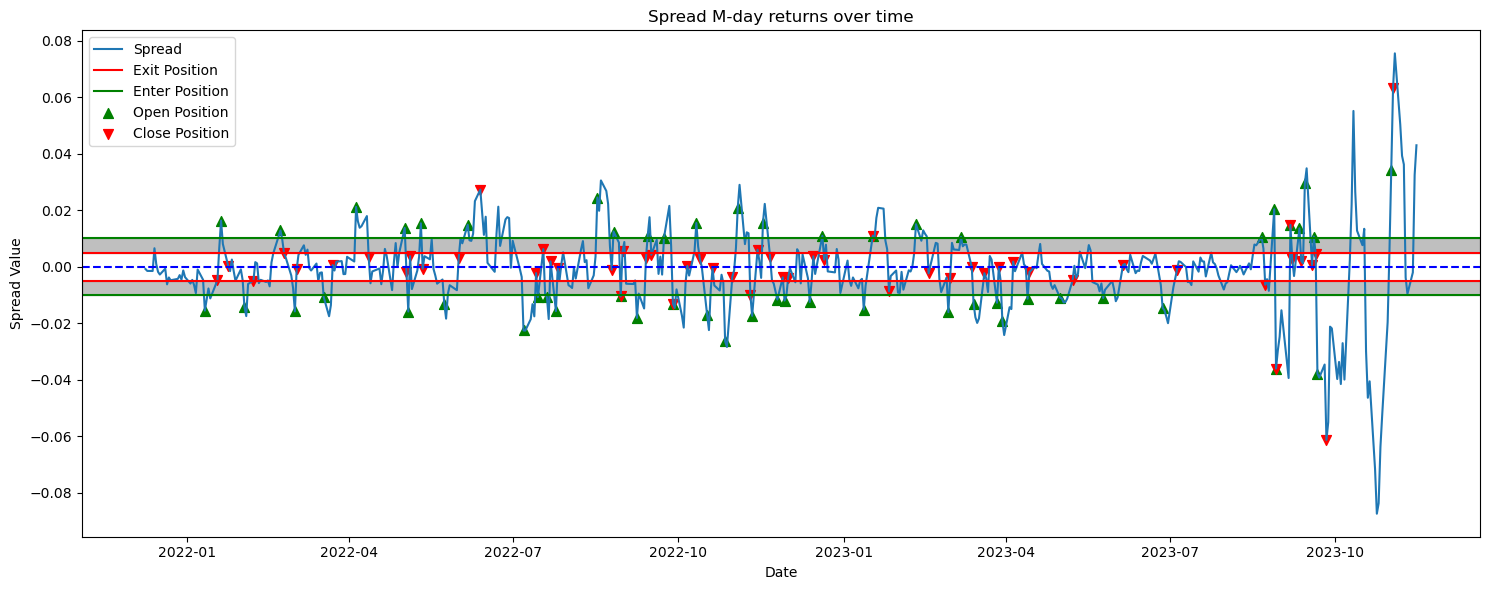

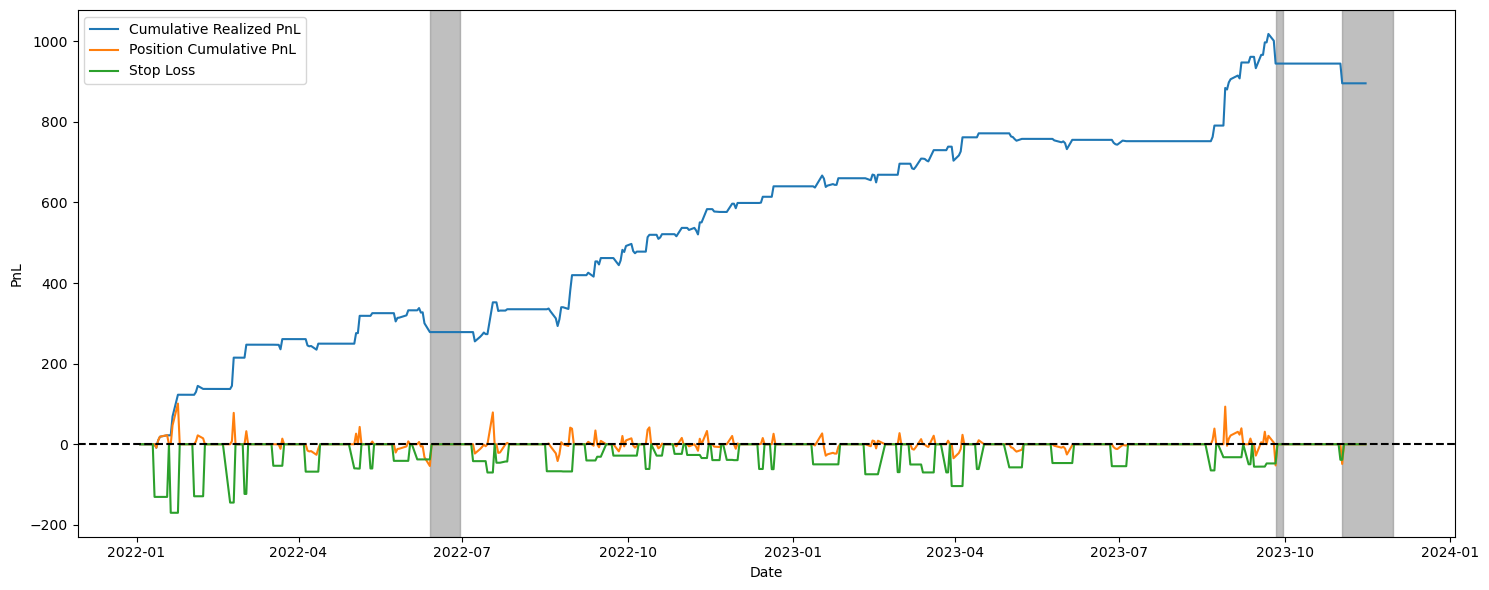

In [811]:
trading_df_grid_search, K_grid_search, no_trading_dates_grid_search = trading_logic(M_grid_search, g_grid_search,
                                                                                    j_grid_search, s_grid_search, zeta,
                                                                                    start_trading_date,
                                                                                    end_trading_date, data, N_t)

open_positions_dates_grid_search, close_positions_dates_grid_search = get_open_close_positions_dates(
    trading_df_grid_search)

display(trading_df_grid_search.tail())

print_performance_metrics(trading_df_grid_search, K_grid_search)

plot_spread_over_time(M_grid_search, g_grid_search, j_grid_search, 0, data, open_positions_dates_grid_search,
                      close_positions_dates_grid_search)

plot_pnl_over_time(trading_df_grid_search, no_trading_dates_grid_search)

We can see that with a very simple grid search optimization method to maximize the cumulative realized PnL, we found better parameters than the ones we initially chose. We can also see that the stop loss parameter is 5 times smaller than the one we initially used. This means that we are more conservative with our stop loss mechanism, which is a good thing because we want to limit our losses as much as possible. The stop loss is triggered 3 times in this new scenario, as we can see with the grey areas on the graph above.

The cumulative realized PnL is twice as high as before, trading costs included, this is mainly due to the fact that we are trading much more often, with 54 trades against 28 before, because of the small thresholds values we are using to enter and exit a position. We are making a lot os small wins and the few big losses are cut short by the stop loss mechanism.

##### 3.2.2. Optuna

If we try to use some more sophisticated optimization methods, we can use the Optuna library which is a hyperparameter optimization framework. Let's also try to explore larger ranges of values for our parameters.

In [812]:
def objective(trial):
    M = trial.suggest_int('M', 1, 40)
    g = trial.suggest_float('g', 0.006, 0.1)
    j = trial.suggest_float('j', 0.001, g)  # j must be less than g
    s = trial.suggest_float('s', 0.01, 0.05)
    zeta = 0.00001

    cumulative_pnl = grid_search(M, g, j, s, zeta, start_trading_date, end_trading_date, data, N_t)
    return cumulative_pnl

In [813]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

best_parameters = study.best_params
best_cumulative_pnl = study.best_value

print(f'Best parameters: {best_parameters}')
print(f'Best cumulative PnL: ${best_cumulative_pnl:.2f}')

[I 2024-01-25 20:39:22,061] A new study created in memory with name: no-name-4567ba2f-333a-4d86-b606-bbd342cdff1b
[I 2024-01-25 20:39:22,081] Trial 0 finished with value: 68.11134453095214 and parameters: {'M': 17, 'g': 0.031056133351172802, 'j': 0.020057408618216994, 's': 0.016823598353941045}. Best is trial 0 with value: 68.11134453095214.
[I 2024-01-25 20:39:22,095] Trial 1 finished with value: 0.0 and parameters: {'M': 1, 'g': 0.07517908522875164, 'j': 0.05381062610250231, 's': 0.012649889736166015}. Best is trial 0 with value: 68.11134453095214.
[I 2024-01-25 20:39:22,107] Trial 2 finished with value: 0.0 and parameters: {'M': 3, 'g': 0.06010332032176521, 'j': 0.04904403361957979, 's': 0.026783263334637188}. Best is trial 0 with value: 68.11134453095214.
[I 2024-01-25 20:39:22,120] Trial 3 finished with value: 241.96093776386834 and parameters: {'M': 40, 'g': 0.030435705379507225, 'j': 0.01145031051450746, 's': 0.016737390586081268}. Best is trial 3 with value: 241.96093776386834.

Best parameters: {'M': 3, 'g': 0.006037322097002175, 'j': 0.0012287168043329775, 's': 0.021021197667888986}
Best cumulative PnL: $1556.87


Let's not forget that here we are optimizing our strategy on the cumulative realized PnL. We could also optimize it on other metrics such as the Sharpe ratio or the Sortino ratio. We will not do it here, but it is something that could be done. The choice of the metric to optimize on depends on the investor's preferences. With high trading fees, we could maybe want to minimize the number of trades for example, while maximizing the cumulative realized PnL.

We can see that we get some parameters close to the ones that we obtained using the previous optimization model. It is again consistent with the comments we made about M and the thresholds. The stop loss parameter is also very small, which is a good thing because we want to limit our losses as much as possible.

In [814]:
start_trading_date = '2022-01-01'
end_trading_date = '2023-11-15'

# Parameters
M_optuna = 3  # Number of days for M-day return
g_optuna = 0.006  # Threshold for entering a position
j_optuna = 0.003  # Threshold for exiting a position - must be lower than g
s_optuna = 0.012  # Stop loss parameter

trading_cost = True  # Whether to include trading cost

if trading_cost:
    zeta = 0.00001  # Trading cost parameter
else:
    zeta = 0

,Cumulative Realized PnL,Position Cumulative PnL,Position Daily PnL,Shares of HYLD (X),Shares of JNK (Y),Gross Trading Cash,Number of Trades,Price of HYLD (X),Price of JNK (Y),Stop Loss Threshold
Date,,,,,,,,,,
2023-11-09,1540.796906,0.0,0.0,0.0,0.0,0.0,101,22.6899,89.253501,0.0
2023-11-10,1540.796906,0.0,0.0,0.0,0.0,0.0,101,22.9006,89.708422,0.0
2023-11-13,1540.796906,0.0,0.0,0.0,0.0,0.0,101,22.8196,89.550189,0.0
2023-11-14,1540.796906,0.0,0.0,0.0,0.0,0.0,101,23.9765,90.469920,0.0
2023-11-15,1540.796906,0.0,0.0,0.0,0.0,0.0,101,24.2400,90.193012,0.0


The final cumulative realized PnL of our strategy is $1540.80.
The return on capital is 0.0908%.


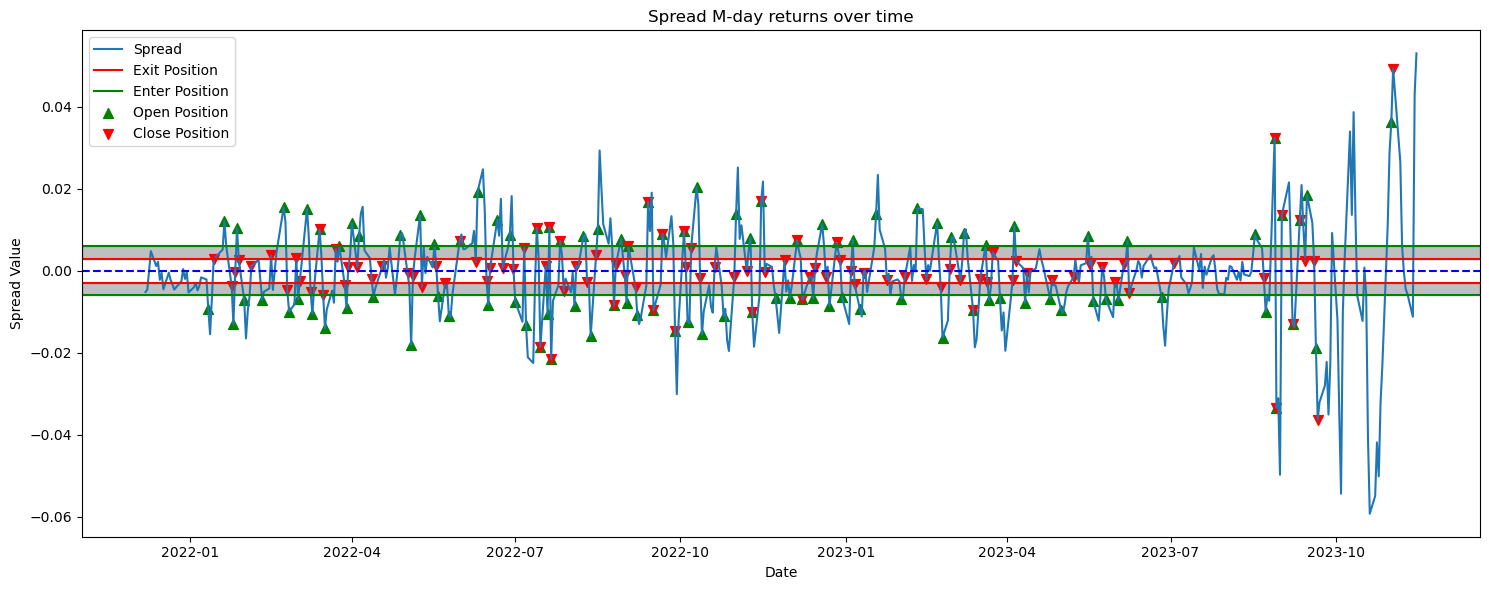

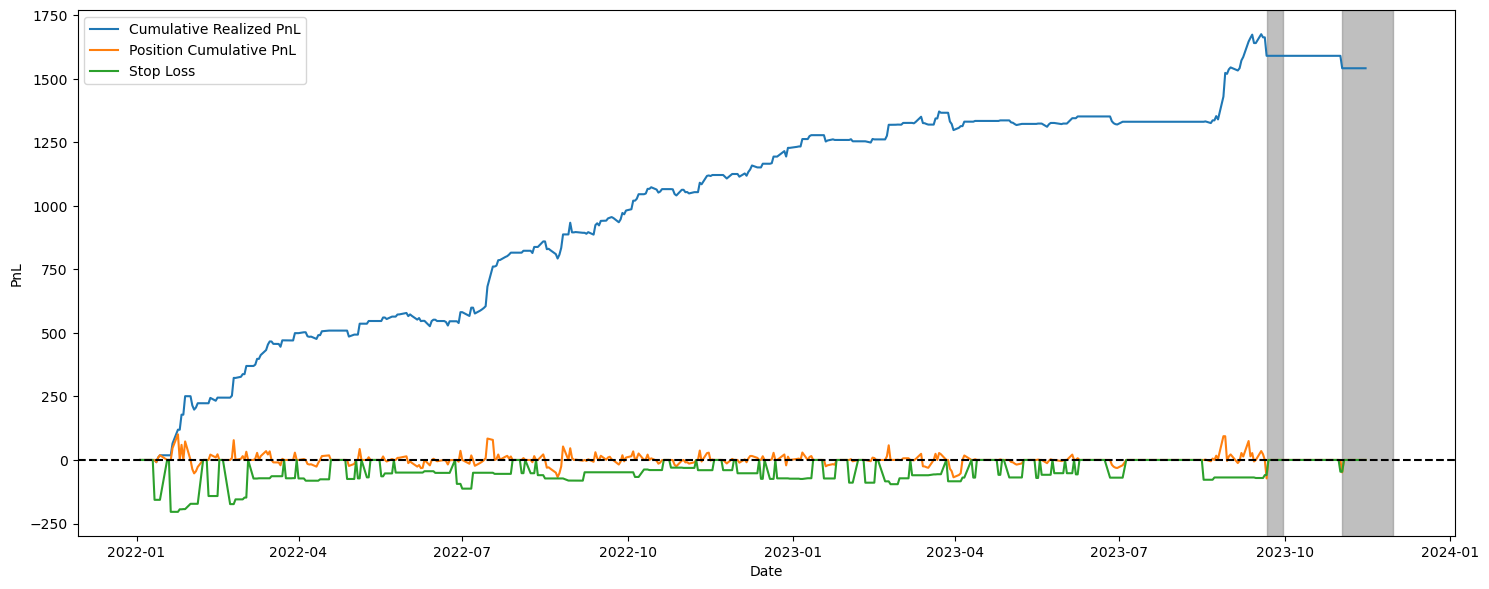

In [815]:
trading_df_optuna, K_optuna, no_trading_dates_optuna = trading_logic(M_optuna, g_optuna, j_optuna, s_optuna, zeta,
                                                                     start_trading_date, end_trading_date, data, N_t)

open_positions_dates_optuna, close_positions_dates_optuna = get_open_close_positions_dates(trading_df_optuna)

display(trading_df_optuna.tail())

print_performance_metrics(trading_df_optuna, K_optuna)

plot_spread_over_time(M_optuna, g_optuna, j_optuna, 0, data, open_positions_dates_optuna, close_positions_dates_optuna)

plot_pnl_over_time(trading_df_optuna, no_trading_dates_optuna)

With a combination of a small threshold difference and a 5-day return, we can see that we are entering a position even more often than before. Indeed, we are making more than a hundred trades over the period of study. We can see that the cumulative realized PnL is much higher than before too, even with trading costs - the stop loss is triggered 2 times in this scenario, when the spread starts to get very volatile at the end of our sample period. Again, we are making a lot of small wins and the few big losses are being prevented by the stop loss mechanism.

### 4. Analysis

Let's select 2 models that worked well for our analysis. We will choose the one we optimized with the Grid Search method and the one we optimized with the Optuna library. To make it simple, we will call those strategies: Grid Search and Optuna.

#### 4.1. Performance Metrics

In order for us to assess the performance of our strategy, we will compute different performance metrics. The first step will be to calculate the strategy returns. Then we could have a look for example at the Sharpe ratio, the maximum drawdown, the volatility or the skewness and kurtosis. We will also compute the empirical VaR and CVaR at 5%.

In [816]:
def calculate_strategy_returns(trading_df):
    trading_df['Strategy Returns'] = trading_df['Cumulative Realized PnL'].pct_change().replace([np.inf, -np.inf],
                                                                                                np.nan)
    # If we are working with some trading costs, the first cumulative realized PnL is equal to a negative small amount which causes the first return to be extremely high, we need to remove this by using the following filter
    trading_df['Strategy Returns'] = np.where(trading_df['Strategy Returns'] > 10, np.nan,
                                              trading_df['Strategy Returns'])
    trading_df['Strategy Returns'].dropna(inplace=True)

In [817]:
calculate_strategy_returns(trading_df_grid_search)

calculate_strategy_returns(trading_df_optuna)

In [818]:
def performance_summary(return_data, rf=None, rb=None, annualization=1):
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x * annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x * np.sqrt(annualization))

    if rf is not None:
        summary_stats['Sharpe Ratio'] = (return_data - rf).mean() / summary_stats['Volatility'] * annualization
    else:
        summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']

    if rb is not None:
        summary_stats['Information Ratio'] = (return_data - rf).mean() / (return_data - rf).std() * np.sqrt(
            annualization)

        downside_returns = np.where(return_data < rb, return_data - rb, 0)
        downside_deviation = np.sqrt(np.mean(downside_returns ** 2))

        summary_stats['Sortino Ratio'] = (return_data - rb).mean() / downside_deviation * np.sqrt(annualization)

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['Empirical VaR (0.05)'] = return_data.quantile(.05, axis=0)
    summary_stats['Empirical CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis=0)].mean()

    wealth_index = 1000 * (1 + return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date

    return summary_stats

In [819]:
perf_grid_search = performance_summary(trading_df_grid_search[['Strategy Returns']]).rename(
    index={'Strategy Returns': 'Performance - Grid Search'})

perf_optuna = performance_summary(trading_df_optuna[['Strategy Returns']]).rename(
    index={'Strategy Returns': 'Performance - Optuna'})

pd.concat([perf_grid_search, perf_optuna], axis=0)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Empirical VaR (0.05),Empirical CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Performance - Grid Search,0.009155,0.153945,0.059472,1.151490,152.856207,-0.019776,-0.131464,-0.0,2022-01-13,2022-01-13,2022-01-13
Performance - Optuna,0.011042,0.168070,0.065699,4.114902,166.948589,-0.018717,-0.121359,-0.0,2022-01-13,2022-01-13,2022-01-13


As can be seen in the dataframe above, both strategies report a positive mean return. Their volatility is similar but because of their difference in mean, the Sharpe Ratio of the Optuna strategy is a little bit higher than the one of the Grid Search strategy.

If we try to look at the tails metrics now, we can see that both strategies have a positive skewness and a large positive excess kurtosis. It means that the tail on the right side of the distribution is longer or fatter than the left side. In the context of investment returns, this implies that there are more frequent small losses and a few large gains. Investors typically view positive skewness favorably because it suggests the potential for occasional large returns, even though most of the returns might be moderate or slightly negative. Also, a positive excess kurtosis indicates a distribution with tails that are heavier than those of a normal distribution. This means the investment strategy has a higher probability of producing extreme returns (both positive and negative) compared to a normal distribution. While this can be appealing due to the possibility of high returns, it also increases the risk of substantial losses.

We can see that the empirical VaR and CVaR at 5% are very similar for both strategies, same thing for the maximum drawdown.

Finally, if we take a look at the Return on Capital of those strategies, we can see that the Optuna strategy do twice as much as the Grid Search strategy. The numbers are very low because of the way we computed our capital K, as 2 times the max of the series $N_t$.

In [820]:
print_performance_metrics(trading_df_grid_search, K_grid_search)
print('\n')
print_performance_metrics(trading_df_optuna, K_optuna)

The final cumulative realized PnL of our strategy is $895.59.
The return on capital is 0.0528%.


The final cumulative realized PnL of our strategy is $1540.80.
The return on capital is 0.0908%.


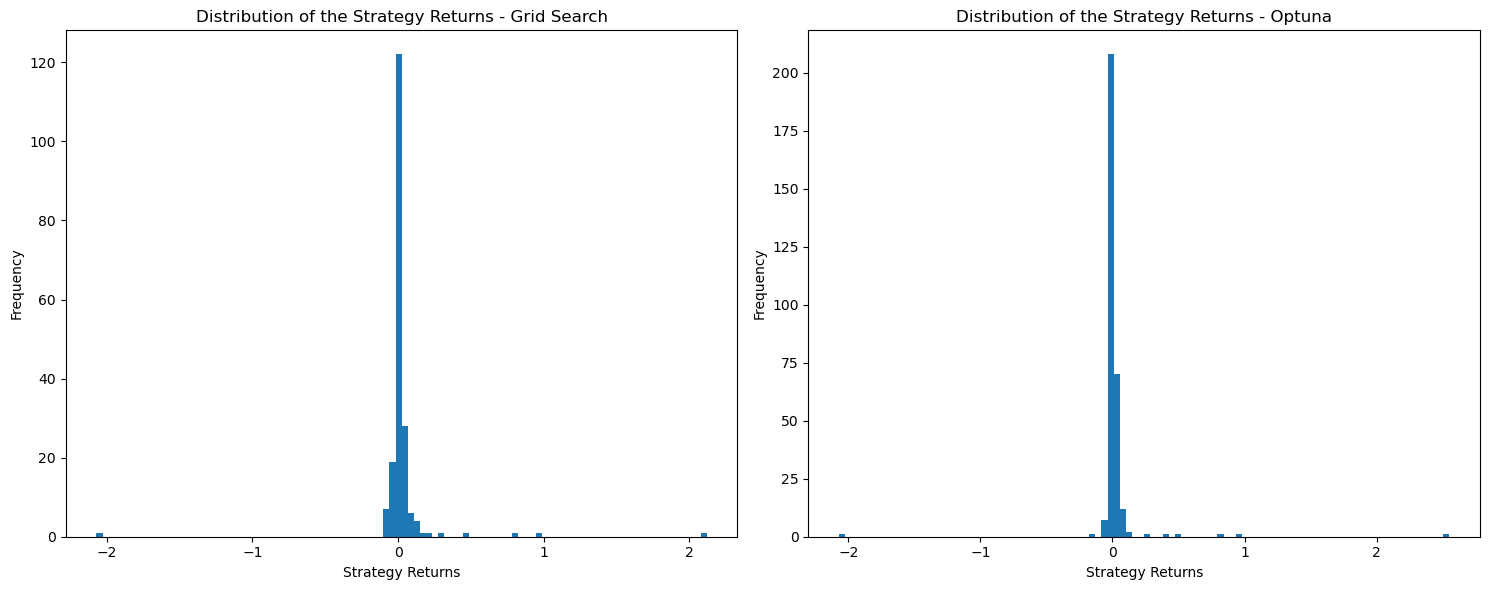

In [821]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(trading_df_grid_search[['Strategy Returns']][trading_df_grid_search['Strategy Returns'] != 0], bins=100)
plt.xlabel('Strategy Returns')
plt.ylabel('Frequency')
plt.title('Distribution of the Strategy Returns - Grid Search')

plt.subplot(1, 2, 2)
plt.hist(trading_df_optuna[['Strategy Returns']][trading_df_optuna['Strategy Returns'] != 0], bins=100)
plt.xlabel('Strategy Returns')
plt.ylabel('Frequency')
plt.title('Distribution of the Strategy Returns - Optuna')

plt.tight_layout()
plt.show()

As can be seen on the histograms above, the distributions of the strategy returns are very similar for both strategies. The distribution is not normal, with a lot of small losses and a few large gains. We represented in this distribution only the non-zero returns to emphasize the behavior of our strategy when we are actually trading.

In [822]:
def downside_beta(market_returns, strategy_returns, threshold=0):
    market_returns = market_returns.loc[strategy_returns.index]

    downside_mask = market_returns < threshold
    downside_market_returns = market_returns[downside_mask]
    downside_strategy_returns = strategy_returns[downside_mask]

    covariance = np.cov(downside_market_returns, downside_strategy_returns)[0, 1]
    variance = np.var(downside_market_returns)

    downside_beta = covariance / variance if variance != 0 else float('inf')

    return downside_beta

In [823]:
downside_beta_df = pd.DataFrame(index=['Downside Beta'])

downside_beta_df['Grid Search'] = downside_beta(FF3['Mkt-RF'], trading_df_grid_search['Strategy Returns'].dropna())

downside_beta_df['Optuna'] = downside_beta(FF3['Mkt-RF'], trading_df_optuna['Strategy Returns'].dropna())

downside_beta_df

,Grid Search,Optuna
Downside Beta,-0.006613,-0.009434


Last for this performance part, by looking at the downside beta, we can infer that both strategies' returns do not look very sensitive to the market returns in cases when the overall market is losing money. Their Downside Beta is close to 0. This assumption will have to be verified but this is a good thing because it means that our strategy is not correlated to the market when it experiences losses, and that it is not very sensitive to its movements in those moments. Therefore, it would appear as a nice diversification tool in a portfolio.

#### 4.2. Backtest

Before shifting to our last part of analysis where we will try to establish some comparison with different benchmarks, let's have a look at how our strategy would have performed on a longer period of time before our sample period. We will use the same parameters as before, but we will shift the start date of our backtest to start in 2016-01-01.

In [824]:
def get_backtest_data(data, code, start_date, end_date):
    ticker_data = get_data_from_ticker(data, code)
    ticker_data = filter_data_on_dates(ticker_data, start_date, end_date)

    clean_data_if_missing_values(ticker_data)

    date_to_datetime(ticker_data)

    return ticker_data

In [825]:
start_data_date = '2015-12-02'
start_backtest_date = '2016-01-01'
end_backtest_date = '2021-12-31'

X_data_backtest = get_backtest_data(prices, X, start_data_date, end_backtest_date)

Y_data_backtest = get_backtest_data(prices, Y, start_data_date, end_backtest_date)

data_backtest = pd.DataFrame({
    'X_price': X_data_backtest['adj_close'],
    'Y_price': Y_data_backtest['adj_close']
})

N_t_backtest = compute_N_t(X_data_backtest, Y_data_backtest).shift()

There are no missing values in the data
There are no missing values in the data


,Cumulative Realized PnL,Position Cumulative PnL,Position Daily PnL,Shares of HYLD (X),Shares of JNK (Y),Gross Trading Cash,Number of Trades,Price of HYLD (X),Price of JNK (Y),Stop Loss Threshold
Date,,,,,,,,,,
2021-12-27,435.306024,0.0,0.0,0.0,0.0,0.0,84,30.279430,100.008151,0.0
2021-12-28,435.306024,0.0,0.0,0.0,0.0,0.0,84,30.313745,99.971397,0.0
2021-12-29,435.306024,0.0,0.0,0.0,0.0,0.0,84,30.148856,99.778437,0.0
2021-12-30,435.306024,0.0,0.0,0.0,0.0,0.0,84,30.185074,99.723306,0.0
2021-12-31,435.306024,0.0,0.0,0.0,0.0,0.0,84,30.089763,99.760060,0.0


The final cumulative realized PnL of our strategy is $435.31.
The return on capital is 0.0107%.


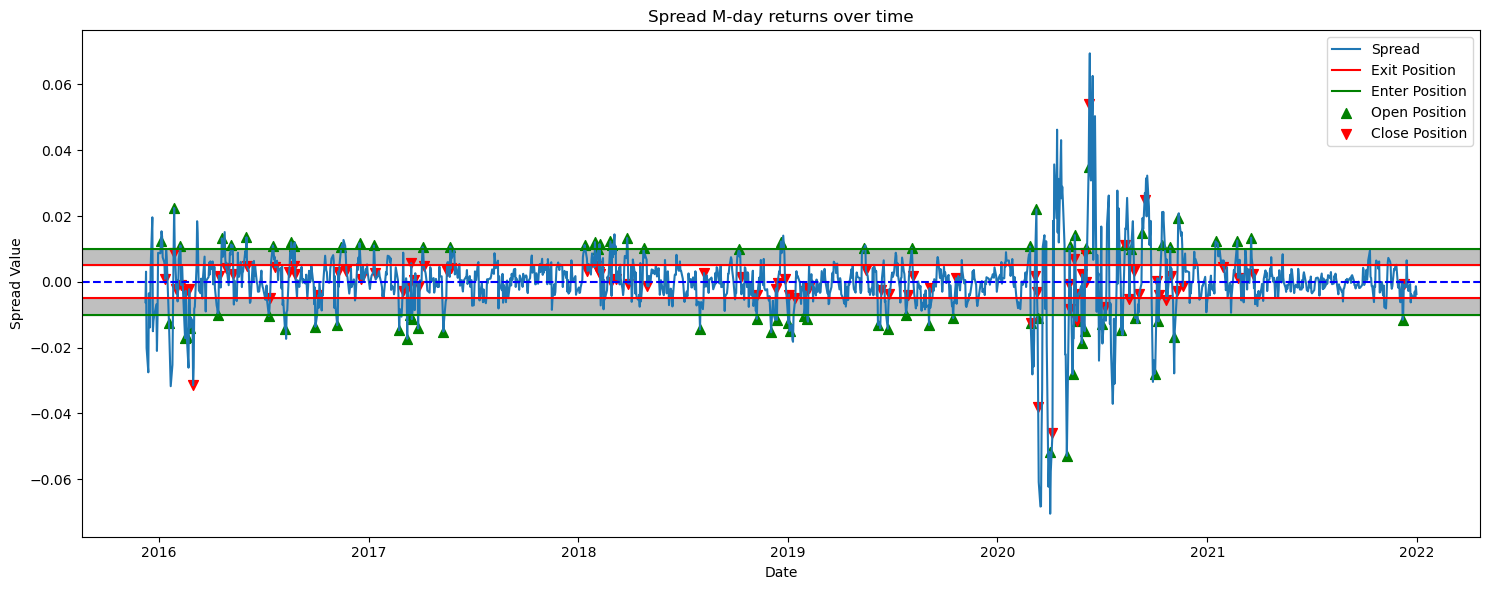

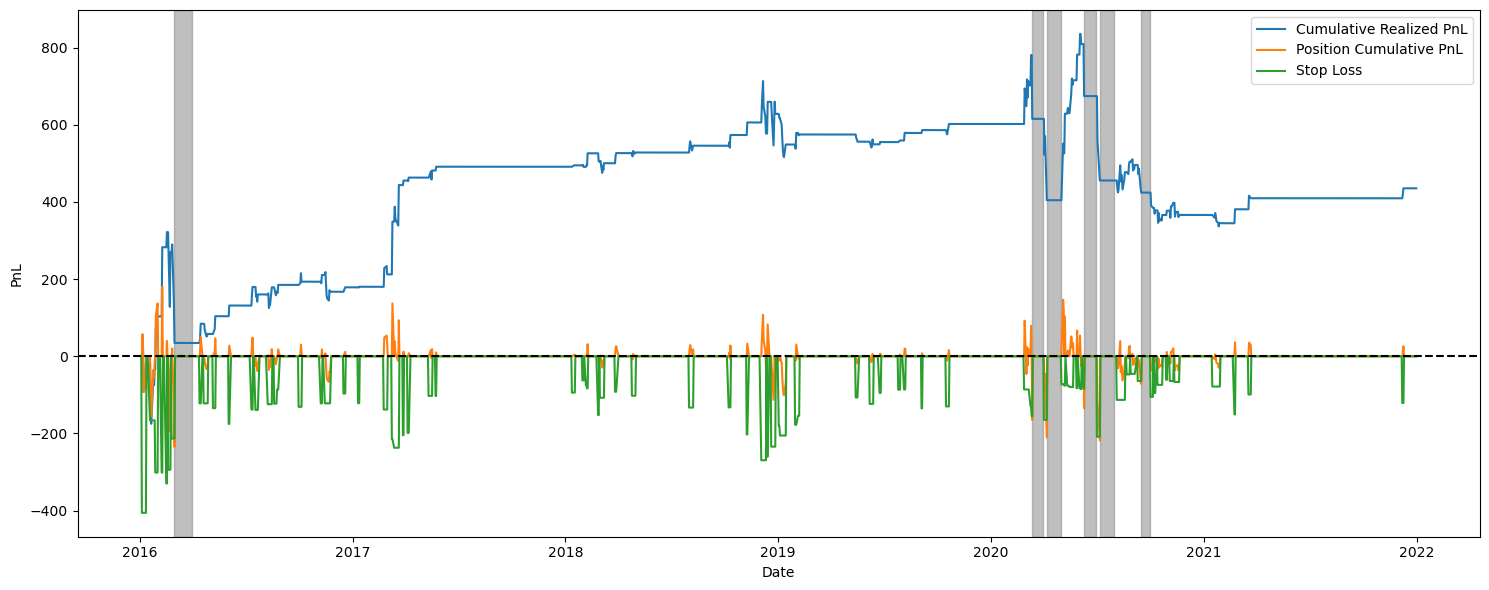

In [826]:
trading_df_grid_search_backtest, K_grid_search_backtest, no_trading_dates_grid_search_backtest = trading_logic(
    M_grid_search, g_grid_search, j_grid_search, s_grid_search, zeta, start_backtest_date, end_backtest_date,
    data_backtest, N_t_backtest)

open_positions_dates_grid_search_backtest, close_positions_dates_grid_search_backtest = get_open_close_positions_dates(
    trading_df_grid_search_backtest)

display(trading_df_grid_search_backtest.tail())

print_performance_metrics(trading_df_grid_search_backtest, K_grid_search_backtest)

plot_spread_over_time(M_grid_search, g_grid_search, j_grid_search, 0, data_backtest,
                      open_positions_dates_grid_search_backtest, close_positions_dates_grid_search_backtest)

plot_pnl_over_time(trading_df_grid_search_backtest, no_trading_dates_grid_search_backtest)

The first thing we can notice with the backtest on the strategy using the Grid Search parameters, is that the stop loss is triggered 5 times but our cumulative realized PnL still suffers from big losses especially at the beginning of the backtesting period and in 2020. Some periods also have very few trades like 2017 or 2021. It appears that the strategy is not very robust and that it is not performing well on this longer period of time with a different market environment. The parameters we found with the Grid Search method are not optimal for this longer period of time, so our strategy must be overfitted to the sample period we used to optimize it.

,Cumulative Realized PnL,Position Cumulative PnL,Position Daily PnL,Shares of HYLD (X),Shares of JNK (Y),Gross Trading Cash,Number of Trades,Price of HYLD (X),Price of JNK (Y),Stop Loss Threshold
Date,,,,,,,,,,
2021-12-27,2510.821903,0.0,0.0,0.0,0.0,0.0,179,30.279430,100.008151,0.0
2021-12-28,2510.821903,0.0,0.0,0.0,0.0,0.0,179,30.313745,99.971397,0.0
2021-12-29,2510.821903,0.0,0.0,0.0,0.0,0.0,179,30.148856,99.778437,0.0
2021-12-30,2510.821903,0.0,0.0,0.0,0.0,0.0,179,30.185074,99.723306,0.0
2021-12-31,2510.821903,0.0,0.0,0.0,0.0,0.0,179,30.089763,99.760060,0.0


The final cumulative realized PnL of our strategy is $2510.82.
The return on capital is 0.0619%.


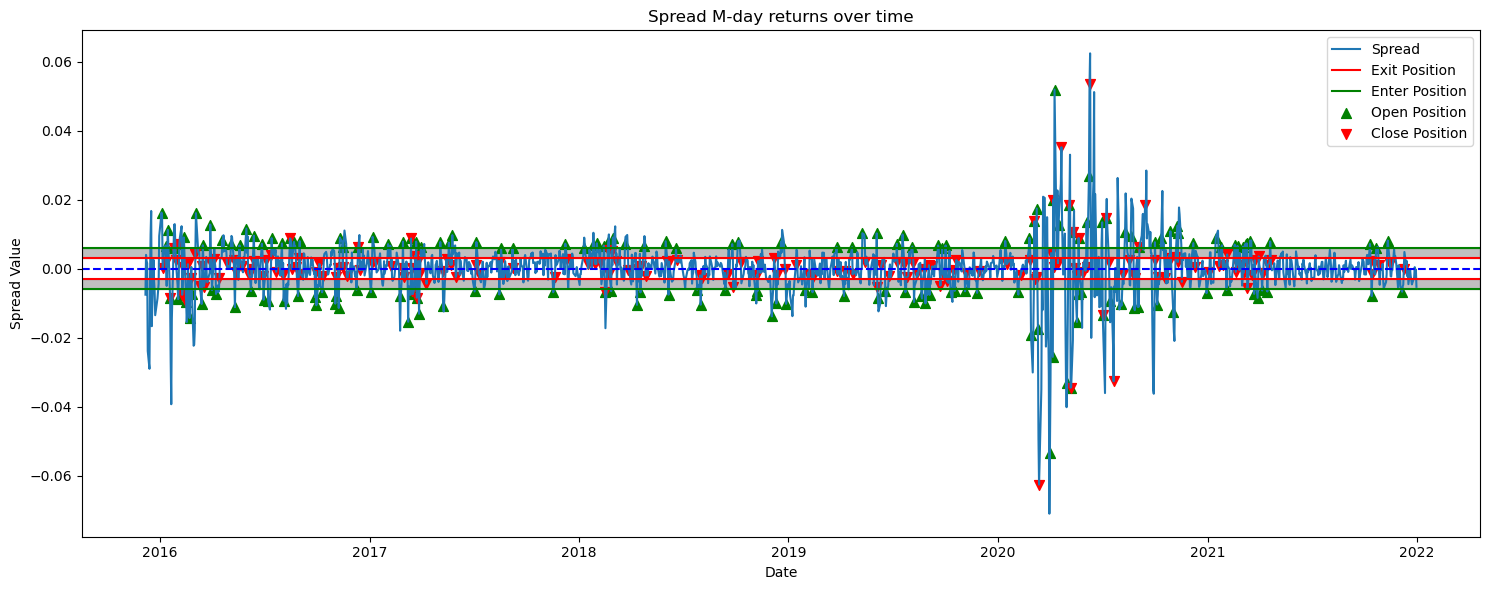

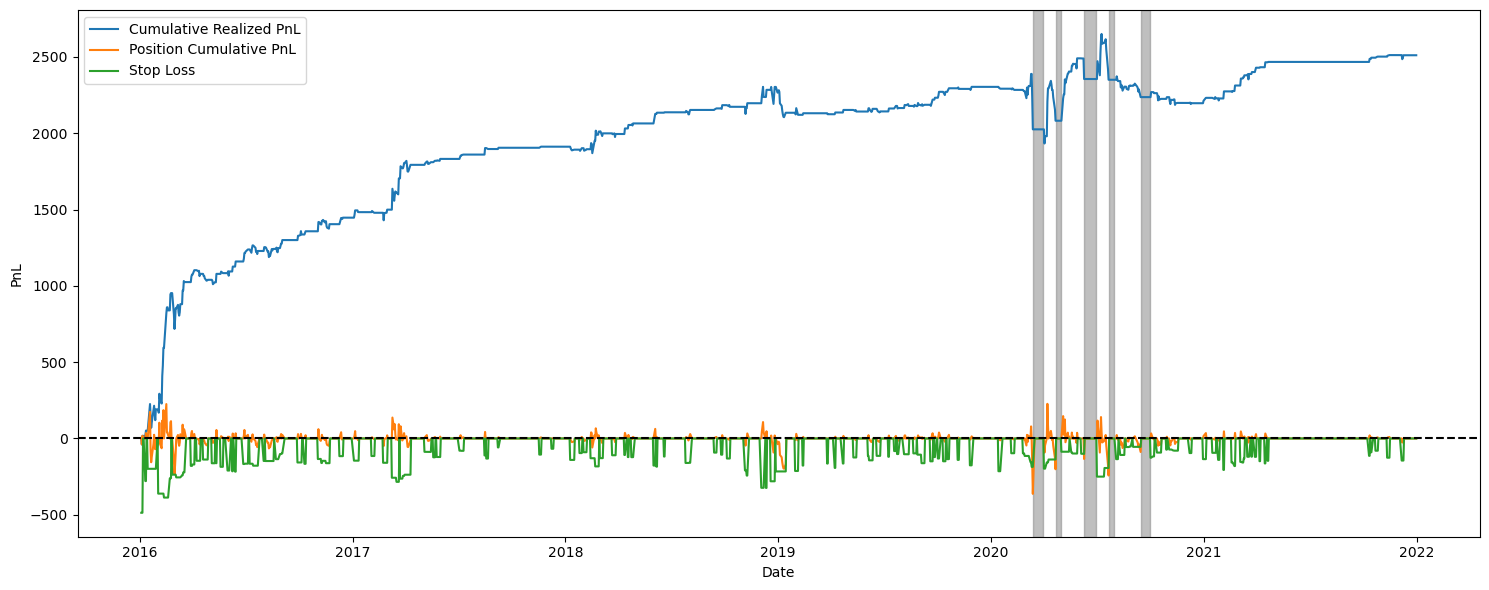

In [827]:
trading_df_optuna_backtest, K_optuna_backtest, no_trading_dates_optuna_backtest = trading_logic(M_optuna, g_optuna,
                                                                                                j_optuna, s_optuna,
                                                                                                zeta,
                                                                                                start_backtest_date,
                                                                                                end_backtest_date,
                                                                                                data_backtest,
                                                                                                N_t_backtest)

open_positions_dates_optuna_backtest, close_positions_dates_optuna_backtest = get_open_close_positions_dates(
    trading_df_optuna_backtest)

display(trading_df_optuna_backtest.tail())

print_performance_metrics(trading_df_optuna_backtest, K_optuna_backtest)

plot_spread_over_time(M_optuna, g_optuna, j_optuna, 0, data_backtest, open_positions_dates_optuna_backtest,
                      close_positions_dates_optuna_backtest)

plot_pnl_over_time(trading_df_optuna_backtest, no_trading_dates_optuna_backtest)

Looking at the backtest on the strategy using the Optuna parameters now, we get better results. The stop loss is triggered 5 times in 2020 and prevents us from suffering large losses. This is why we manage to get a cumulative realized PnL with very few drawdowns. The strategy is also trading quite often, with almost 200 trades over the backtesting period. We can see that the strategy is performing well on this longer period of time with a different market environment. The parameters we found with the Optuna library are more robust and the strategy is probably less overfitted to the sample period we used to optimize it.

#### 4.3. Correlation to Fama-French Factors

Evaluating our trading strategy in relation to the Fama-French Three-Factor Model by analyzing both correlation and regression coefficients is important for providing a comprehensive understanding of a strategy's behavior in relation to well-known market factors, assisting in risk assessment, performance evaluation, and strategic decision-making.

The correlation will help identify the degree to which the strategy's returns move in tandem with each of the Fama-French factors (market, size, value). This can indicate whether the strategy is sensitive to general market movements, size-based anomalies, or value-driven aspects. If we then run a regression on those factors and our returns, the regression coefficients will provide insight into the sensitivity of the strategy's returns to changes in each factor. A high coefficient for a particular factor suggests that the strategy is more exposed to, or reliant on, that factor for its performance.

Understanding the degree of exposure to different risk factors also enables better risk management. For example, if a strategy shows high sensitivity to the market factor, it might be more vulnerable during market downturns, suggesting a need for appropriate hedging or diversification strategies. Analyzing how much of the strategy's performance is attributable to market, size, and value factors also helps in distinguishing between returns generated by systematic factor exposure and those due to specific selection or timing skills.

If a strategy shows low correlation or sensitivity to common risk factors, it might offer diversification benefits in a broader investment portfolio. This can be particularly valuable in managing overall portfolio risk. By understanding a strategy's factor exposures, investors can compare it more effectively with appropriate benchmarks or other investment strategies.

Finally, regular analysis of factor exposures can reveal changes over time, known as style drift. This is crucial for ensuring that the strategy stays aligned with its intended investment mandate or style.

In [828]:
def correlation_to_ff_factors(trading_df, FF3):
    merged_data = pd.merge(trading_df[['Strategy Returns']], FF3, left_index=True, right_index=True, how='inner')

    correlations = merged_data[['Strategy Returns', 'Mkt-RF', 'SMB', 'HML']].corr()

    ff_correlations_grid_search = correlations.iloc[0, 1:]

    return ff_correlations_grid_search.rename('Correlation to FF3 Factors')

In [829]:
corr_grid_search_FF3 = correlation_to_ff_factors(trading_df_grid_search, FF3)
corr_optuna_FF3 = correlation_to_ff_factors(trading_df_optuna, FF3)

corr = pd.merge(corr_grid_search_FF3, corr_optuna_FF3, left_index=True, right_index=True, how='inner',
                suffixes=(' - Grid Search', ' - Optuna'))
corr

,Correlation to FF3 Factors - Grid Search,Correlation to FF3 Factors - Optuna
Mkt-RF,-0.040422,-0.027724
SMB,-0.036376,-0.041822
HML,-0.031169,-0.036191


The correlation matrix between the strategy's total returns and the Fama-French factors shows the following relationships:

* Strategy Returns vs Mkt-RF (Market Risk Factor):

The strategies show a negative correlation with the Market Risk Factor, although very weak, this suggests that the returns have a slight inverse relationship with the market returns. It implies that when the market performs well, the strategy tends to perform marginally worse, and vice versa.

* Strategy Returns vs SMB (Size Factor):

Both strategies have a correlation close to -4% with the Size Factor, indicating again a small relationship with this factor (performance differential between small-cap and large-cap stocks). Therefore, the strategies' performances appears to be mostly independent of size-based market anomalies.

* Strategy Returns vs HML (Value Factor):

Again both strategies show a weak negative correlation with the Value Factor, around -3%. It indicates that the "Grid Search" strategy and the "Optuna" strategy may perform slightly worse when value stocks outperform growth stocks (high book-to-market stocks outperform low book-to-market stocks), and vice versa.

In [830]:
def time_series_regression(portfolio, factors, FF3F=False, resid=False, annualization=1):
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'Alpha'] = res.params['const'] * annualization
        ff_report.loc[portf, 'Market Beta'] = res.params.iloc[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params.iloc[2]
            ff_report.loc[portf, 'Value beta'] = res.params.iloc[3]

        ff_report.loc[portf, 'Information Ratio'] = np.sqrt(annualization) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'Treynor Ratio'] = annualization * portfolio[portf].mean() / res.params.iloc[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std() * np.sqrt(annualization))

        if resid:
            bm_residuals[portf] = res.resid

    if resid:
        return bm_residuals

    return ff_report

In [831]:
reg_grid_search_FF3 = time_series_regression(trading_df_grid_search[['Strategy Returns']],
                                             FF3.loc[trading_df_grid_search.index, ['Mkt-RF', 'SMB', 'HML']],
                                             FF3F=True).rename(index={'Strategy Returns': 'Reg. FF3 - Optuna'})

reg_optuna_FF3 = time_series_regression(trading_df_optuna[['Strategy Returns']],
                                        FF3.loc[trading_df_optuna.index, ['Mkt-RF', 'SMB', 'HML']], FF3F=True).rename(
    index={'Strategy Returns': 'Reg. FF3 - Grid Search'})

pd.concat([reg_grid_search_FF3, reg_optuna_FF3], axis=0)

,Alpha,Market Beta,Size beta,Value beta,Information Ratio,Treynor Ratio,R-squared,Tracking Error
Reg. FF3 - Optuna,0.008671,-0.011537,-0.019421,-0.014415,0.056535,-0.793550,0.007395,0.153375
Reg. FF3 - Grid Search,0.010508,-0.010721,-0.022195,-0.015580,0.062735,-1.029983,0.006701,0.167506


The regression analysis for the two trading strategies using the Fama-French 3-Factor Model (FF3) reveals several key insights into their performance and risk characteristics.

For the "Grid Search" strategy, the analysis indicates an alpha of 0.8671%, signaling a positive excess return over the benchmark. The strategy shows a slight negative sensitivity to market movements, as suggested by a market beta of -0.0115. Both size and value betas, at -0.0194 and -0.0144 respectively, hint at minimal influence from these factors. The Information Ratio stands at 0.0565, reflecting a moderate level of excess return relative to non-systematic risk. The Treynor Ratio, however, is -0.7935, which due to the negative market beta, demands a cautious interpretation. The R-squared value of 0.7395% suggests that the FF3 factors explain only a small portion of the strategy's returns, and the Tracking Error of 0.1534% indicates the strategy's deviation from the benchmark.

In contrast, the "Optuna" strategy exhibits an annualized alpha of 1.0508%, suggesting slightly higher excess returns compared to the "Grid Search" strategy. It also displays a slight negative market sensitivity with a beta of -0.0107. Similar to the "Grid Search" strategy, the size and value betas are -0.0222 and -0.0156, indicating minimal influence from these factors. The Information Ratio is marginally higher at 0.0627, implying a slightly better risk-adjusted performance. The Treynor Ratio is -1.0300, and like the "Grid Search" strategy, it should be interpreted with caution due to the negative market beta. With an R-squared value of 0.6701%, the FF3 factors explain a similarly small portion of the strategy's returns as in the "Grid Search" strategy. The Tracking Error is 0.1675%, suggesting a bit more deviation from the benchmark compared to "Grid Search".

Overall, both strategies demonstrate minimal sensitivity to market, size, and value factors, as evidenced by their negative betas. They generate positive excess returns, as shown by their positive alphas. The low R-squared values indicate that a significant portion of the strategies' returns are influenced by factors outside the FF3 model. The Information Ratios point to moderately efficient performance in generating excess return per unit of non-systematic risk. However, the interpretation of the Treynor Ratios is less straightforward due to the negative market betas. These findings imply that the unique risk-return profiles of these strategies are not fully captured by the traditional market, size, and value factors of the FF3 model.

#### 4.4. Relationship to SVOL Levels

Market volatility plays a pivotal role in spread trading, primarily influencing the spread width and the predictability of price movements. In volatile markets, spreads tend to widen, reflecting increased uncertainty and heightened risk. This widening can offer more profit potential if predictions are accurate, but it also amplifies the potential for loss. Furthermore, the unpredictable nature of price swings in such conditions makes it challenging to forecast movements accurately, thereby increasing the risk involved in spread trades. So we are now going to look at the correlation between the SVOL levels and our strategy's trading rate and profitability to better understand the relationship between market volatility and our strategy's performance.

In [832]:
def correlation_to_svol_levels(trading_df, SVOL_data):
    merged_data = pd.merge(trading_df[['Cumulative Realized PnL', 'Number of Trades']], SVOL_data[['adj_close']],
                           left_index=True, right_index=True, how='inner')
    merged_data.rename(columns={'adj_close': 'SVOL Levels'}, inplace=True)

    merged_data['Days'] = range(1, len(merged_data) + 1)
    merged_data['Trading Rate'] = merged_data['Number of Trades'] / merged_data['Days']
    merged_data['Profitability'] = merged_data['Cumulative Realized PnL'] / merged_data['Number of Trades']

    correlations = merged_data[['Trading Rate', 'Profitability', 'SVOL Levels']].corr()

    svol_correlations = correlations.loc[['Trading Rate', 'Profitability'], 'SVOL Levels']

    return svol_correlations.rename('Correlation to SVOL Levels'), merged_data

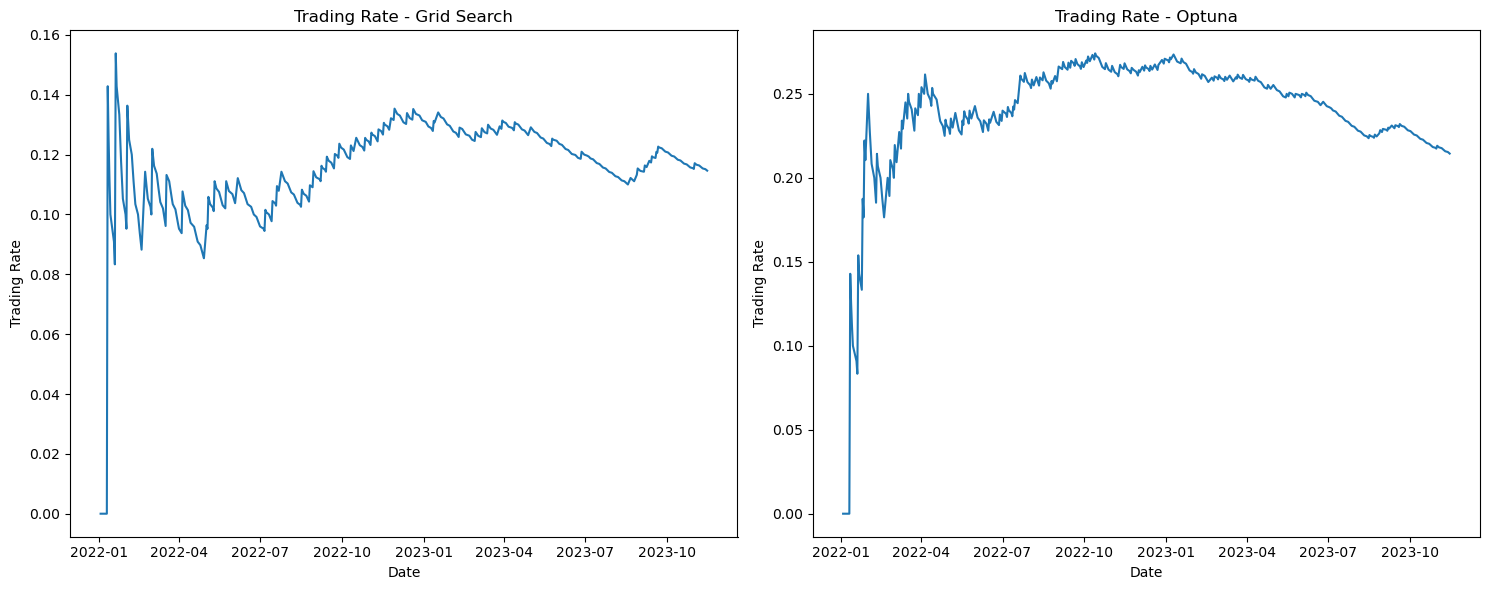

,Correlation to SVOL Levels - Grid Search,Correlation to SVOL Levels - Optuna
Trading Rate,-0.298409,-0.518731
Profitability,-0.049034,-0.029313


In [833]:
corr_grid_search_SVOL, merged_data_grid_search = correlation_to_svol_levels(trading_df_grid_search, SVOL_data)
corr_optuna_SVOL, merged_data_optuna = correlation_to_svol_levels(trading_df_optuna, SVOL_data)

corr_SVOL = pd.merge(corr_grid_search_SVOL, corr_optuna_SVOL, left_index=True, right_index=True, how='inner',
                     suffixes=(' - Grid Search', ' - Optuna'))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(merged_data_grid_search.index, merged_data_grid_search['Trading Rate'])
plt.xlabel('Date')
plt.ylabel('Trading Rate')
plt.title('Trading Rate - Grid Search')

plt.subplot(1, 2, 2)
plt.plot(merged_data_optuna.index, merged_data_optuna['Trading Rate'])
plt.xlabel('Date')
plt.ylabel('Trading Rate')
plt.title('Trading Rate - Optuna')

plt.tight_layout()
plt.show()

corr_SVOL

The correlation analysis between the SVOL levels and both the trading rate and profitability of the "Grid Search" and "Optuna" strategies yields the following insights.

For the trading rate correlation with SVOL levels, we can observe that the Grid Search strategy and the Optuna strategy both have a very negative correlation, respectively -30% and -52%. This suggests that as market volatility (SVOL levels) increases, the trading rate (number of trades per day) in the 'Grid Search' strategy tends to decrease. This is consistent with the fact that as the market is being more volatile, the prices of our ETFs are themselves being more volatiles which could cause our spread to move strongly. Therefore, our stop loss would be activated to prevent losses and block trades.

Looking now at the profitability and its correlation with SVOL levels, both strategies show a low negative correlation. This is not very conclusive, but it could indicate that as market volatility increases, the profitability of the strategies tends to decrease. This could be due to the fact that the strategies are less active in more volatile markets, as we saw with the trading rate correlation, and therefore generate fewer profits.

In both strategies, the negative correlations imply that increased market volatility (as represented by SVOL levels) tends to decrease both the trading rate and profitability. This might indicate that in more volatile markets, the strategies succeed in reducing their trading activity, as a risk management measure thanks to the stop loss mechanism. This is particularly relevant for spread trading strategies, where market volatility can significantly impact the dynamics of price relationships and the effectiveness of trades based on those relationships.

### 5. Conclusion

In this analysis, we developed, optimized, and evaluated a spread trading strategy using two high-yield bond ETFs: **HYLD** (X) and **JNK** (Y). The project was divided into several key stages: data manipulation, strategy implementation and optimization, and performance analysis.

First, we collected and cleaned relevant data, focusing on the ETFs **HYLD** (X), **JNK** (Y), and the volatility ETF **SVOL**. The data was aligned and processed to provide a consistent basis for analysis.

Then, the core of our work was to design a spread trading strategy based on the principle of mean reversion. Key parameters of our strategy included the look-back period (M), entry (g) and exit (j) thresholds, stop-loss (s), and trading cost (zeta). We used two optimization methods, Grid Search and Optuna, to find the best set of parameters. The Optuna optimization proved more effective, delivering higher returns with better robustness in different market conditions.

The next step of our work was to conduct a thorough performance analysis using various metrics, including Sharpe ratio, drawdown, volatility, skewness, and kurtosis. The Optuna strategy outperformed the Grid Search in terms of higher cumulative realized PnL and return on capital, despite a similar level of volatility. Our backtest over a longer period also revealed that the Optuna strategy performed consistently well, while the Grid Search strategy was less robust and seemed to be overfitted to the sample period.

In our analysis, we also examined the correlation between the strategies' returns and the Fama-French three-factor model. The two strategies exhibited a weak negative correlation with market, size, and value factors. They – Grid Search and Optuna – demonstrated minimal sensitivity to three factors, as evidenced by their negative betas in the regression also. This suggests that the strategies are not highly sensitive to these common market trends, which could be advantageous for diversification within a broader investment portfolio.

Following this, we investigated the relationship between our strategies and market volatility, as represented by **SVOL** levels. The results showed a very negative correlation between **SVOL** levels and the trading rate for both strategies. Specifically, as market volatility increased, the trading frequency of both strategies tended to decrease, likely due to the activation of the stop-loss mechanism to mitigate risks in more volatile markets. Additionally, a slight negative correlation was observed between **SVOL** levels and the strategies' profitability, indicating that higher market volatility might slightly reduce the profitability of the trades. This underscores the impact of market volatility on the dynamics and effectiveness of spread trading strategies, emphasizing the importance of risk management measures like stop-loss in volatile market conditions.

The analysis demonstrated the effectiveness of a carefully designed and optimized spread trading strategy using ETFs. The strategy showed potential for consistent returns with controlled risk, especially in the context of diversification and market volatility. The Optuna-based strategy, in particular, showed promise due to its robustness and adaptability across different market conditions.